In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib

# Add code directory to path
sys.path.insert(0, r'C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code')

# Force reload to get latest changes
if 'DiffLenExt' in sys.modules:
    importlib.reload(sys.modules['DiffLenExt'])
if 'perpendicular' in sys.modules:
    importlib.reload(sys.modules['perpendicular'])

from DiffLenExt import DiffusionLengthExtractor
from perpendicular import gradient_with_window

print("Imports successful!")


Imports successful!


In [2]:
# Set up paths
data_dir = Path(r'C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\perpendicular_plots\25B2_P4_80kx_30um')
vb_input = "0, 02,04,06"
profile_input = "1,2,3,4,5,6,7,8"
# -------------------------------------------

# Parse VB tokens into filename substrings (case-insensitive)
vb_tokens = [t.strip() for t in vb_input.split(',') if t.strip()]
vb_patterns = []
for t in vb_tokens:
    tt = t.lower()
    if tt in ('0', 'novb', 'no', 'n'):           # treat as noVb
        vb_patterns.append('novb')
    elif tt.startswith('vb'):                     # user passed "VB02" or "vb02"
        num = tt[2:]
        vb_patterns.append('vb' + num)
        vb_patterns.append('vb' + num.zfill(2))
    else:                                         # numeric like "2","02","08"
        vb_patterns.append('vb' + tt)             # vb2
        vb_patterns.append('vb' + tt.zfill(2))    # vb02

# Parse profile numbers into filename substrings
profile_tokens = [p.strip() for p in profile_input.split(',') if p.strip()]
profile_patterns = []
for p in profile_tokens:
    try:
        n = int(p)
        profile_patterns.append(f"profile_{n:02d}")
    except ValueError:
        # if user typed the full substring already, accept it
        profile_patterns.append(p.lower())

# Collect and filter CSV files (case-insensitive match)
all_csv = sorted(list(data_dir.glob('*.csv')))
csv_files = []
for f in all_csv:
    name_l = f.name.lower()
    if any(v in name_l for v in vb_patterns) and any(p in name_l for p in profile_patterns):
        csv_files.append(f)

print(f"Found {len(csv_files)} CSV files matching VB={vb_input} profiles={profile_input}")
for f in csv_files:
    print(f"  {f.name}")

Found 32 CSV files matching VB=0, 02,04,06 profiles=1,2,3,4,5,6,7,8
  25B2_P4_80kx_30um_noVb_profile_01.csv
  25B2_P4_80kx_30um_noVb_profile_02.csv
  25B2_P4_80kx_30um_noVb_profile_03.csv
  25B2_P4_80kx_30um_noVb_profile_04.csv
  25B2_P4_80kx_30um_noVb_profile_05.csv
  25B2_P4_80kx_30um_noVb_profile_06.csv
  25B2_P4_80kx_30um_noVb_profile_07.csv
  25B2_P4_80kx_30um_noVb_profile_08.csv
  25B2_P4_80kx_30um_Vb02_profile_01.csv
  25B2_P4_80kx_30um_Vb02_profile_02.csv
  25B2_P4_80kx_30um_Vb02_profile_03.csv
  25B2_P4_80kx_30um_Vb02_profile_04.csv
  25B2_P4_80kx_30um_Vb02_profile_05.csv
  25B2_P4_80kx_30um_Vb02_profile_06.csv
  25B2_P4_80kx_30um_Vb02_profile_07.csv
  25B2_P4_80kx_30um_Vb02_profile_08.csv
  25B2_P4_80kx_30um_Vb04_profile_01.csv
  25B2_P4_80kx_30um_Vb04_profile_02.csv
  25B2_P4_80kx_30um_Vb04_profile_03.csv
  25B2_P4_80kx_30um_Vb04_profile_04.csv
  25B2_P4_80kx_30um_Vb04_profile_05.csv
  25B2_P4_80kx_30um_Vb04_profile_06.csv
  25B2_P4_80kx_30um_Vb04_profile_07.csv
  25B2_P4_80

In [3]:
# Load a single profile for testing
test_file = csv_files[0]  # Change index to test different profiles
print(f"Loading: {test_file.name}")

df = pd.read_csv(test_file)
print(f"\nColumns: {df.columns.tolist()}")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Loading: 25B2_P4_80kx_30um_noVb_profile_01.csv

Columns: ['distance_um', 'sem_raw', 'sem_normalized', 'current_nA', 'current_log_safe', 'is_junction']
Shape: (138, 6)

First few rows:


,distance_um,sem_raw,sem_normalized,current_nA,current_log_safe,is_junction
0,-0.250000,10654.530481,0.409514,0.175942,0.175942,No
1,-0.246350,10944.745546,0.447056,0.226613,0.226613,No
2,-0.242701,12084.889150,0.594543,0.197928,0.197928,No
3,-0.239051,12375.789316,0.632174,0.231344,0.231344,No
4,-0.235401,11964.024614,0.578909,0.182093,0.182093,No


In [4]:
# Extract data
x_vals = df['distance_um'].values
y_vals = df['current_nA'].values

# Find junction index
junction_idx = df[df['is_junction'] == 'Yes'].index
if len(junction_idx) > 0:
    junction_idx = junction_idx[0]
else:
    # Find maximum current as junction
    junction_idx = np.argmax(y_vals)

print(f"Junction index: {junction_idx}")
print(f"Junction position: {x_vals[junction_idx]:.3f} µm")
print(f"Current range: {y_vals.min():.3e} to {y_vals.max():.3e} nA")

Junction index: 67
Junction position: -0.005 µm
Current range: 4.603e-02 to 2.422e+01 nA


Forced junction index at x=0 -> idx: 68, position: -0.001825 µm


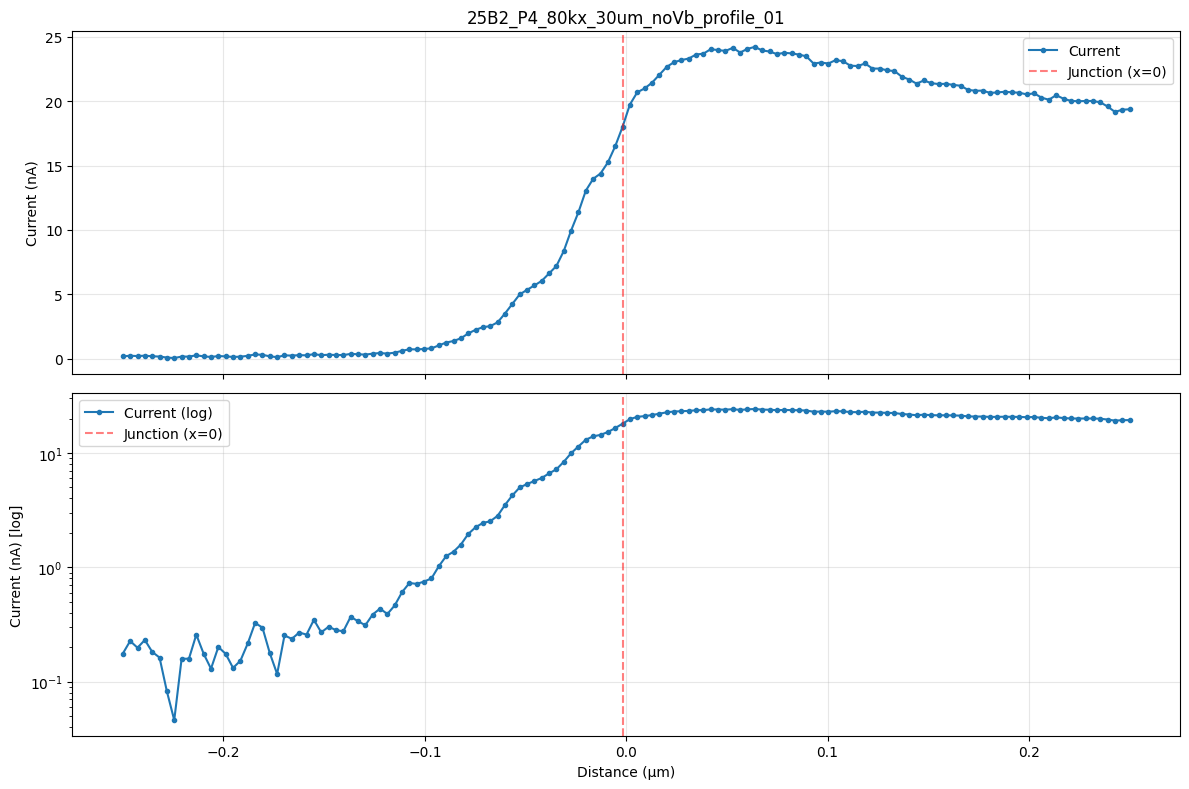

In [5]:
# Force junction to x = 0 (choose the index closest to 0)
junction_idx = int(np.argmin(np.abs(x_vals - 0.0)))
print(f"Forced junction index at x=0 -> idx: {junction_idx}, position: {x_vals[junction_idx]:.6f} µm")

# Plot the raw data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Linear scale
ax1.plot(x_vals, y_vals, 'o-', markersize=3, label='Current')
ax1.axvline(x_vals[junction_idx], color='red', linestyle='--', alpha=0.5, label='Junction (x=0)')
ax1.set_ylabel('Current (nA)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title(f'{test_file.stem}')

# Log scale
pos = y_vals[y_vals > 0]
floor = max(np.min(pos) * 0.1, 1e-12) if pos.size > 0 else 1e-12
y_safe = np.maximum(y_vals, floor)
ax2.plot(x_vals, y_safe, 'o-', markersize=3, label='Current (log)')
ax2.axvline(x_vals[junction_idx], color='red', linestyle='--', alpha=0.5, label='Junction (x=0)')
ax2.set_yscale('log')
ax2.set_xlabel('Distance (µm)')
ax2.set_ylabel('Current (nA) [log]')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Function to fit and plot multiple profiles with adjustable parameters
def fit_and_plot_profiles(csv_files, params, debug=True):
    """
    Fit linear models to multiple perpendicular profiles.
    
    Args:
        csv_files: List of CSV file paths to process
        params: Dictionary of fitting parameters
    
    Returns:
        List of extractor objects (one per file)
    """
    extractors = []
    pixel_size = 1e-6  # 1 µm
    
    for csv_file in csv_files:
        # Load data
        df = pd.read_csv(csv_file)
        x_vals = df['distance_um'].values
        y_vals = df['current_nA'].values
        
        # Find junction index (closest to x=0)
        junction_idx = int(np.argmin(np.abs(x_vals - 0.0)))
        
        # Create profile dict
        profile = {
            'id': 0,
            'dist_um': x_vals,
            'sem': df['sem_raw'].values,
            'current': y_vals,
            'intersection_idx': junction_idx,
            'source_name': csv_file.name
        }
        
        # Initialize extractor and load profile
        extractor = DiffusionLengthExtractor(pixel_size, smoothing_sigma=1)
        extractor.load_profiles([profile])
        
        # Run fitting
        extractor.fit_all_profiles_linear(**params)
        
        # Plot results
        if debug:
            plot_fitting_results(extractor, csv_file.name)
        
        extractors.append(extractor)
    
    return extractors


def plot_fitting_results(extractor, filename):
    """
    Plot fitting results for a single profile.
    EXACT copy from helper_gui.py plotting function.
    """
    if not extractor.results:
        print("No results to plot")
        return
    
    res = extractor.results[0]
    profile_idx = res.get('Profile', 1)
    depletion = res.get('depletion', {})
    best_left = depletion.get('best_left_fit')
    best_right = depletion.get('best_right_fit')
    
    left_slope = best_left.get('slope') if best_left is not None else None
    left_r2 = best_left.get('r2') if best_left is not None else None
    right_slope = best_right.get('slope') if best_right is not None else None
    right_r2 = best_right.get('r2') if best_right is not None else None
    left_start = depletion.get('left_start')
    right_start = depletion.get('right_start')
    depletion_width = depletion.get('depletion_width')
    
    # Extract profile data
    profile_entry = extractor.profiles[profile_idx - 1]
    x = np.array(profile_entry.get('dist_um', []), dtype=float)
    y = np.array(profile_entry.get('current', []), dtype=float)
    
    # Center x axis at the detected junction
    intersection_idx = profile_entry.get('intersection_idx', None)
    if intersection_idx is not None and 0 <= int(intersection_idx) < len(x):
        ref = float(x[int(intersection_idx)])
        base_idx = int(intersection_idx)
    else:
        base_idx = int(np.argmax(y))
        ref = float(x[base_idx])
    
    # Build ln(current) from raw data
    pos = y[y > 0]
    floor = max(np.min(pos) * 0.1, 1e-12) if pos.size > 0 else 1e-12
    y_safe = np.maximum(y, floor)
    ln_y = np.log(y_safe)
    
    # Compute filtered signal (used internally for fits) and its ln
    try:
        y_filtered = extractor.apply_low_pass_filter(y, visualize=False)
        y_filtered_safe = np.maximum(y_filtered, floor)
        ln_y_filtered = np.log(y_filtered_safe)
    except Exception:
        y_filtered = None
        ln_y_filtered = None
    
    # Create a 2-row figure: top = ln(Current) and fits, bottom = derivatives
    fig, (ax, ax_der) = plt.subplots(2, 1, sharex=True, figsize=(10, 7), gridspec_kw={'height_ratios': [2, 1]})
    x_plot = x - ref
    
    # Plot raw ln(Current)
    ax.plot(x_plot, ln_y, 'k.-', label='ln(Current) (raw)')
    
    # Plot filtered ln(Current) if available (smooth line)
    if ln_y_filtered is not None:
        ax.plot(x_plot, ln_y_filtered, color='tab:orange', lw=1.8, alpha=0.9, label='ln(Current) (filtered)')
    
    # Overlay best-left/right fits
    if best_left is not None:
        if 'global_x_vals' in best_left:
            x_fit = np.array(best_left['global_x_vals'], dtype=float) - ref
            if 'ln_fit_curve' in best_left:
                y_fit = np.array(best_left['ln_fit_curve'], dtype=float)
            else:
                y_fit = np.log(np.maximum(np.array(best_left.get('fit_curve', [])), floor))
        else:
            x_fit = -np.array(best_left.get('x_vals', []), dtype=float) - ref
            y_fit = np.array(best_left.get('slope', 0.0)) * np.array(best_left.get('x_vals', []), dtype=float) + best_left.get('intercept', 0.0)
        ax.plot(x_fit, y_fit, 'b-', lw=2.0, label=f"Left fit (s={left_slope:.3g}, R²={left_r2:.2f})")
        if left_start is not None:
            ax.axvline(left_start - ref, color='b', linestyle='--')
    
    if best_right is not None:
        if 'global_x_vals' in best_right:
            x_fit = np.array(best_right['global_x_vals'], dtype=float) - ref
            if 'ln_fit_curve' in best_right:
                y_fit = np.array(best_right['ln_fit_curve'], dtype=float)
            else:
                y_fit = np.log(np.maximum(np.array(best_right.get('fit_curve', [])), floor))
        else:
            x_fit = np.array(best_right.get('x_vals', []), dtype=float) - ref
            y_fit = np.array(best_right.get('slope', 0.0)) * np.array(best_right.get('x_vals', []), dtype=float) + best_right.get('intercept', 0.0)
        ax.plot(x_fit, y_fit, 'r-', lw=2.0, label=f"Right fit (s={right_slope:.3g}, R²={right_r2:.2f})")
        if right_start is not None:
            ax.axvline(right_start - ref, color='r', linestyle='--')
    
    # Shade depletion region
    if left_start is not None and right_start is not None:
        ax.axvspan(left_start - ref, right_start - ref, color='green', alpha=0.12)
    
    # Highlight detected plateau regions (if available)
    if best_left is not None and 'plateau_indices' in best_left:
        idx_start, idx_end = best_left['plateau_indices']
        if idx_start < len(x) and idx_end <= len(x):
            plat_x_start = x[idx_start] - ref
            plat_x_end = x[idx_end - 1] - ref
            ax.axvspan(plat_x_start, plat_x_end, color='blue', alpha=0.08, label='Left plateau region')
    
    if best_right is not None and 'plateau_indices' in best_right:
        idx_start, idx_end = best_right['plateau_indices']
        if idx_start < len(x) and idx_end <= len(x):
            plat_x_start = x[idx_start] - ref
            plat_x_end = x[idx_end - 1] - ref
            ax.axvspan(plat_x_start, plat_x_end, color='red', alpha=0.08, label='Right plateau region')
    
    ax.set_xlabel('Distance (µm)')
    ax.set_ylabel('ln(Current)')
    ax.set_title(f"{filename}\nDepletion width = {depletion_width if depletion_width is not None else float('nan'):.3g} µm")
    ax.legend(fontsize='small')
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # --- Derivative panel: d(lnI)/dx ---
    gradient_window = extractor.plateau_params.get('gradient_window', 9)
    try:
        x_vals_plot = np.array(x_plot, dtype=float)
        if x_vals_plot.size > 1:
            source_ln = ln_y
            dln_meas = gradient_with_window(x_vals_plot, source_ln, window=gradient_window)
        else:
            dln_meas = np.zeros_like(x_vals_plot)
    except Exception:
        dln_meas = np.zeros_like(x_plot)
    
    ax_der.plot(x_plot, dln_meas, color='tab:gray', linestyle=':', label='dlnI/dx (raw)', alpha=0.6)
    
    # Compute and plot derivative of filtered signal
    if ln_y_filtered is not None:
        try:
            if x_vals_plot.size > 1:
                dln_filtered = gradient_with_window(x_vals_plot, ln_y_filtered, window=gradient_window)
                ax_der.plot(x_plot, dln_filtered, color='tab:orange', linestyle='-', lw=1.5, 
                           label='dlnI/dx (filtered)', alpha=0.9)
        except Exception as e:
            print(f"Warning: Could not compute filtered derivative: {e}")
    
    # Overlay fit-derived dlnI/dx when available
    try:
        def _get_fit_derivative_mapped(fit_dict, side):
            if fit_dict is None:
                return None, None
            if 'global_x_vals' in fit_dict:
                fx = np.array(fit_dict['global_x_vals'], dtype=float) - ref
            elif 'global_x' in fit_dict:
                fx = np.array(fit_dict['global_x'], dtype=float) - ref
            else:
                if side == 'Left':
                    fx = -np.array(fit_dict.get('x_vals', []), dtype=float) - ref
                else:
                    fx = np.array(fit_dict.get('x_vals', []), dtype=float) - ref
            
            if 'fit_dlnI_dx' in fit_dict:
                fdln = np.array(fit_dict['fit_dlnI_dx'], dtype=float)
            else:
                fc = np.array(fit_dict.get('fit_curve', []), dtype=float)
                if fx.size > 1 and fc.size == fx.size:
                    try:
                        fdln = gradient_with_window(fx + ref, np.log(np.maximum(fc, 1e-12)), window=gradient_window)
                    except Exception:
                        fdln = None
                else:
                    fdln = None
            return fx, fdln
        
        left_fx, left_fdln = _get_fit_derivative_mapped(best_left, 'Left')
        right_fx, right_fdln = _get_fit_derivative_mapped(best_right, 'Right')
        
        if left_fx is not None and left_fdln is not None:
            si = np.argsort(left_fx)
            lf = left_fx[si]
            ld = left_fdln[si]
            ax_der.plot(lf, ld, 'b-', lw=1.6, label='dlnI/dx (left fit)')
        
        if right_fx is not None and right_fdln is not None:
            si = np.argsort(right_fx)
            rf = right_fx[si]
            rd = right_fdln[si]
            ax_der.plot(rf, rd, 'r-', lw=1.6, label='dlnI/dx (right fit)')
    except Exception as e:
        print(f"Error plotting derivatives: {e}")
    
    ax_der.set_xlabel('Distance (µm)')
    ax_der.set_ylabel('dlnI/dx (1/µm)')
    ax_der.grid(True, linestyle='--', alpha=0.4)
    ax_der.legend(fontsize='small')
    
    fig.tight_layout()
    plt.show()

print("Functions defined successfully!")


Functions defined successfully!


C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


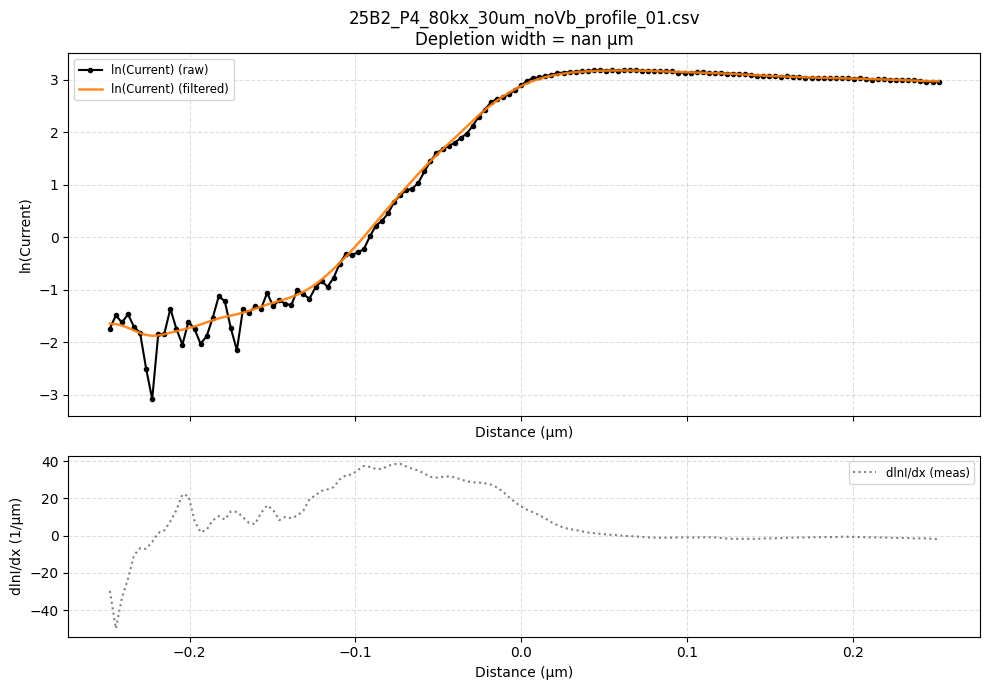

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


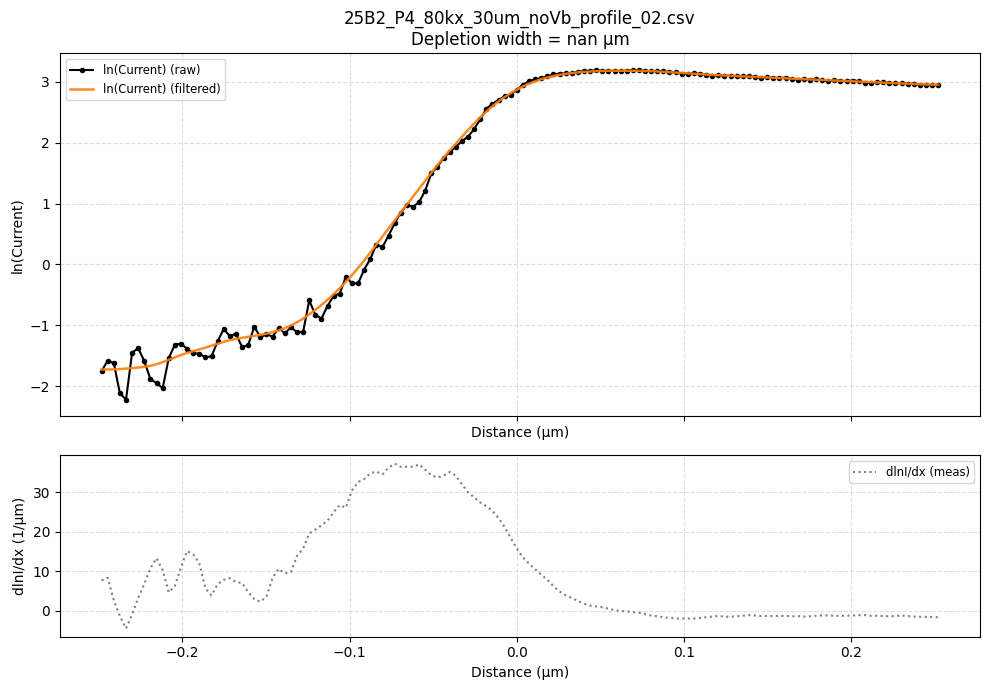

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


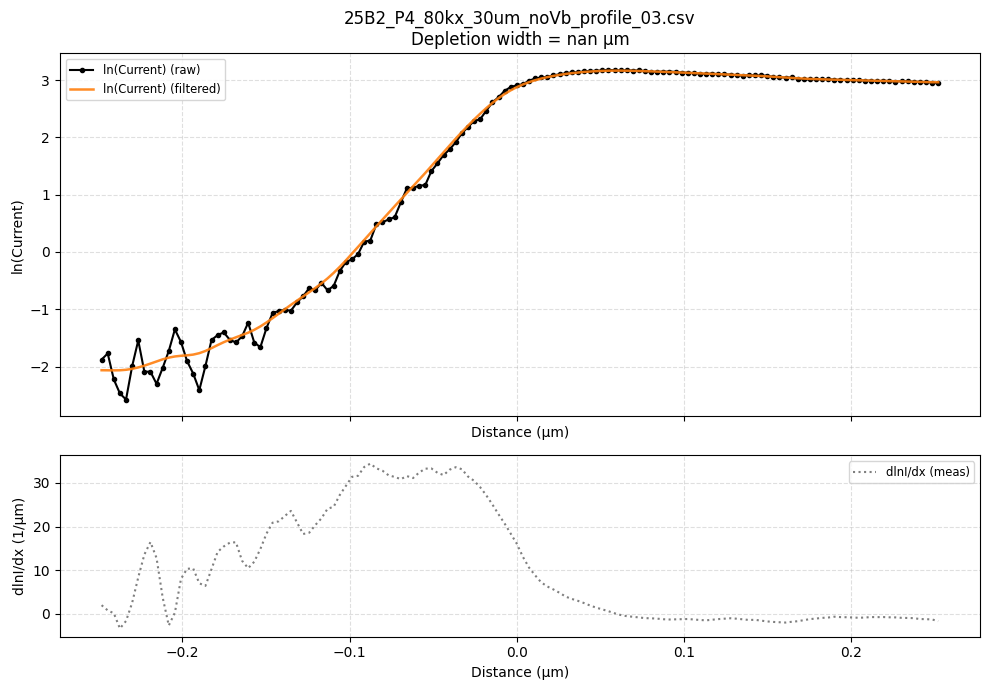

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


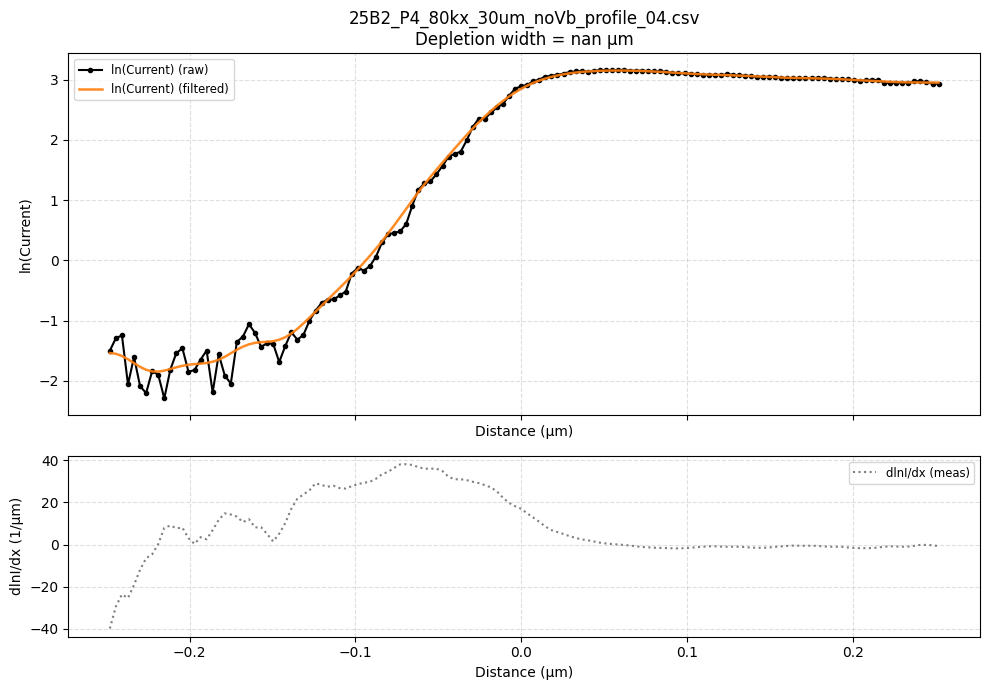

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


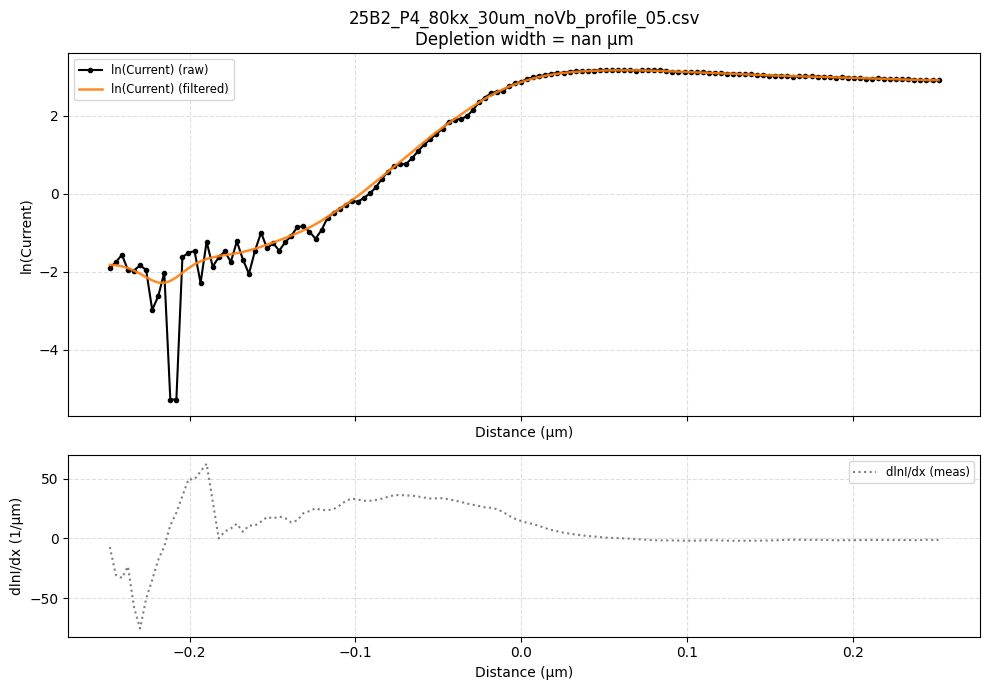

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


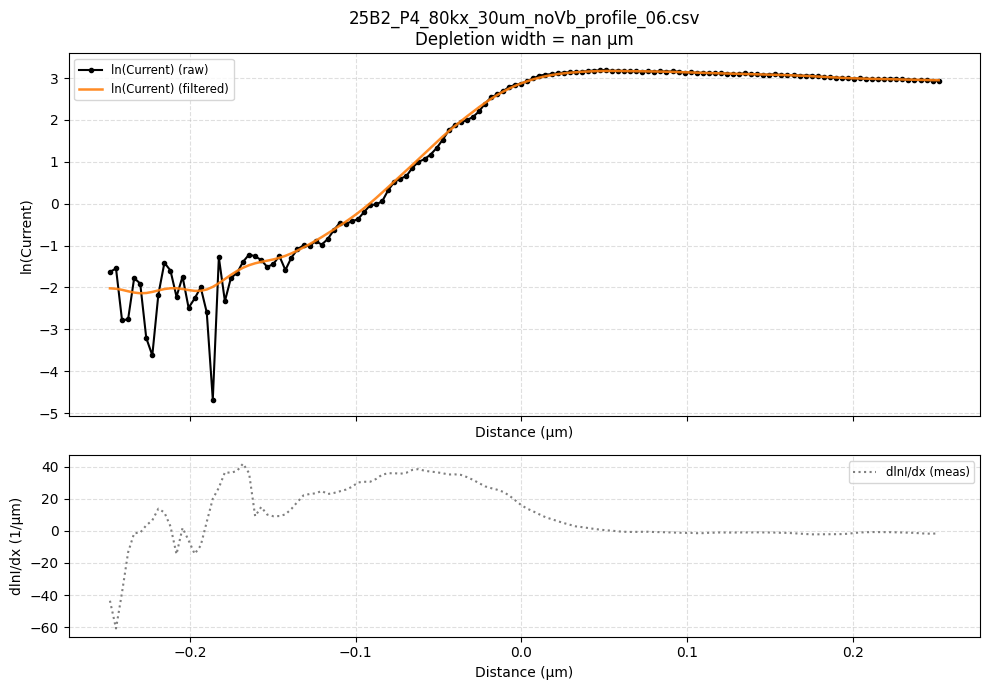

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


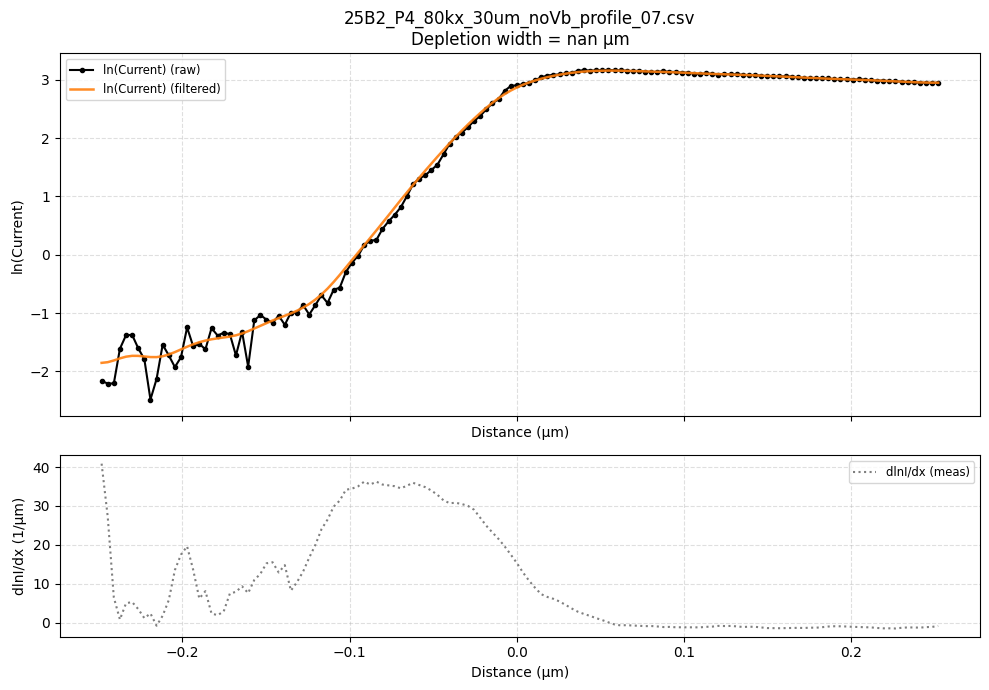

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


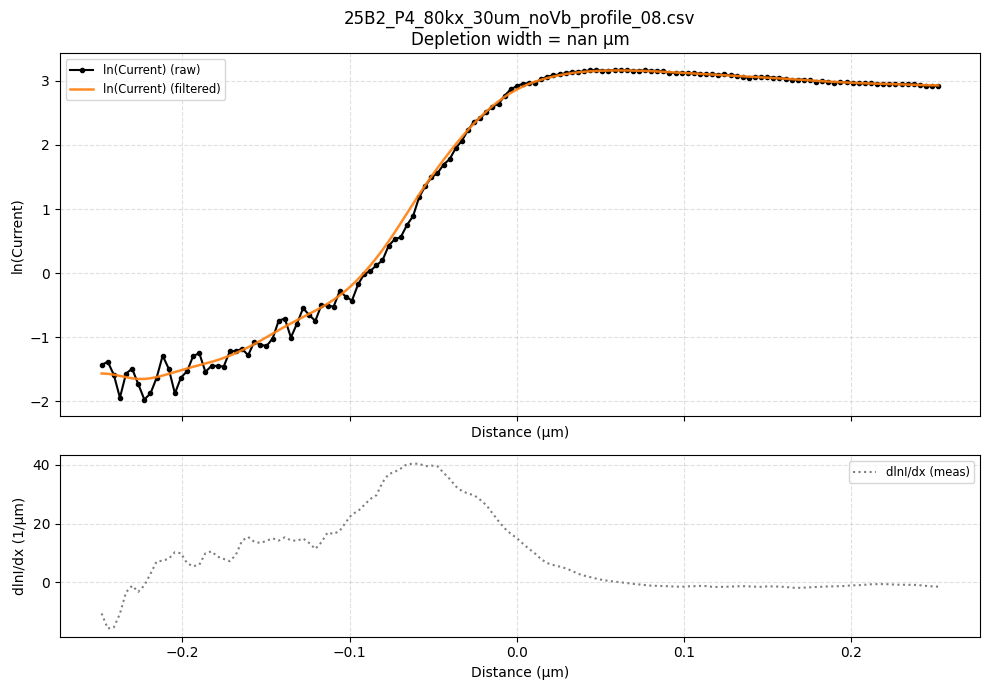

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


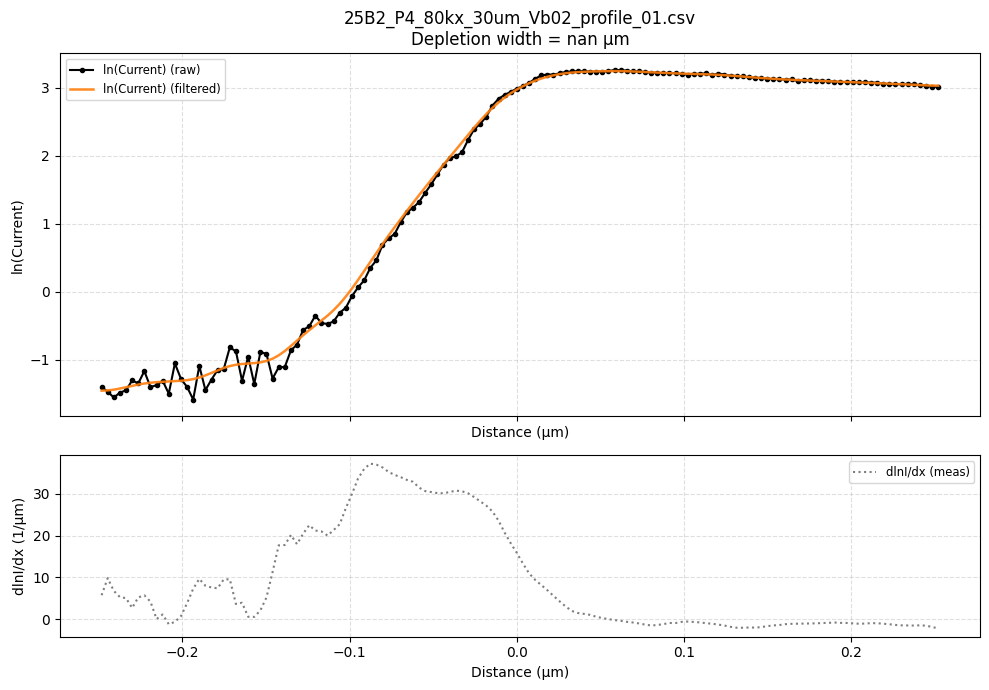

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


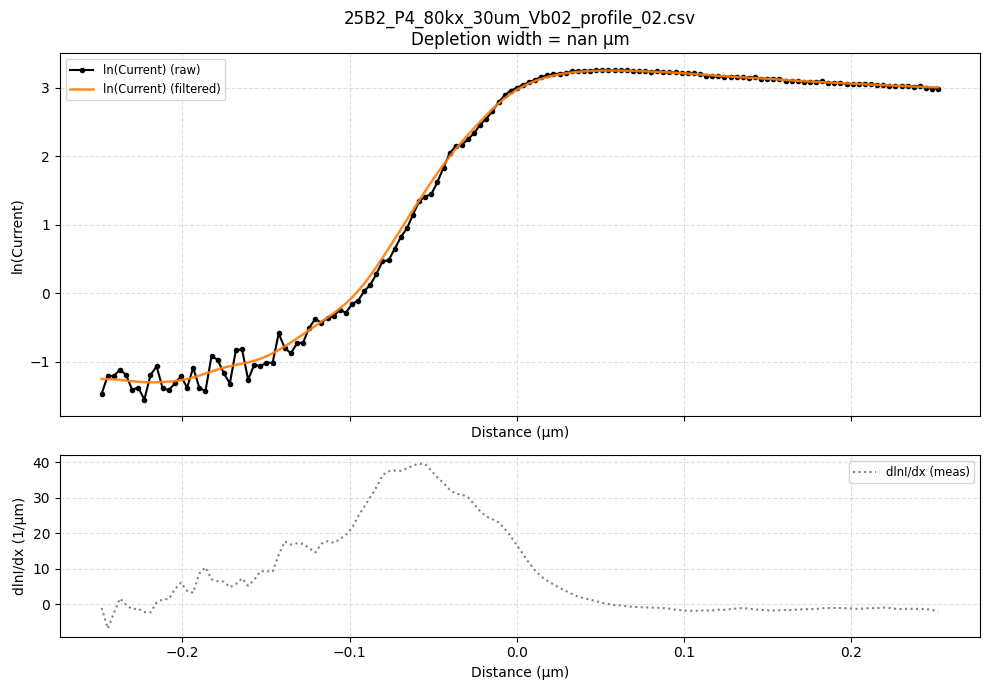

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


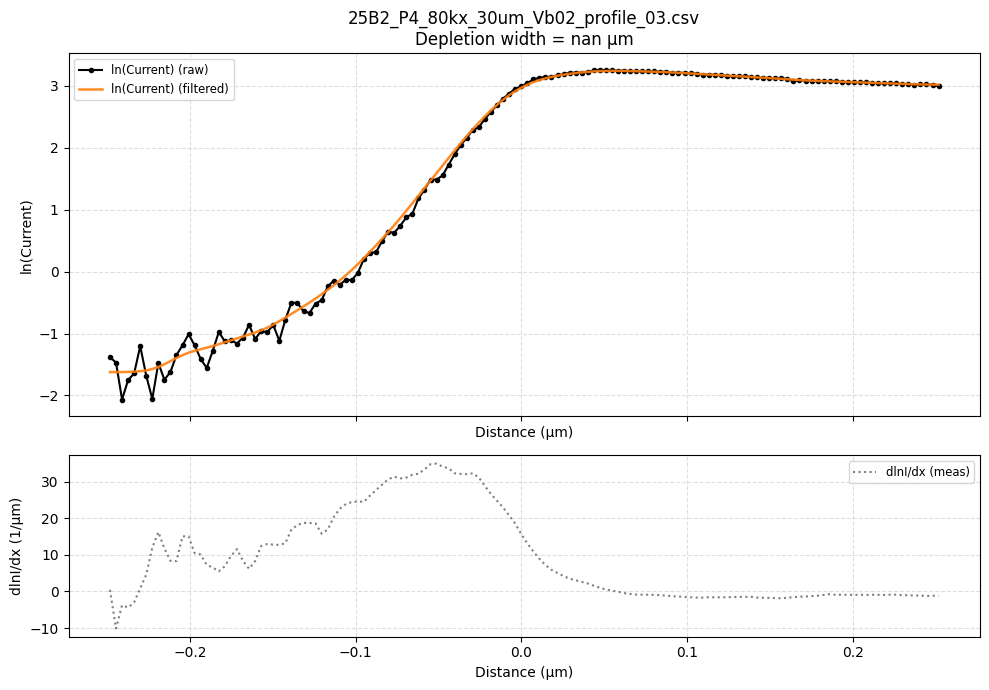

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


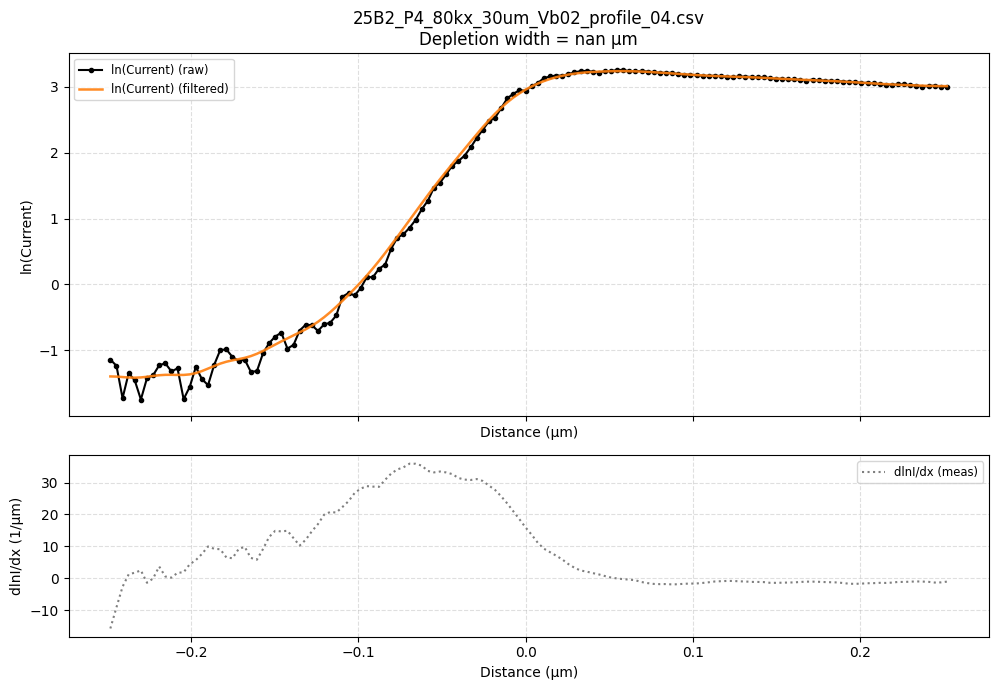

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


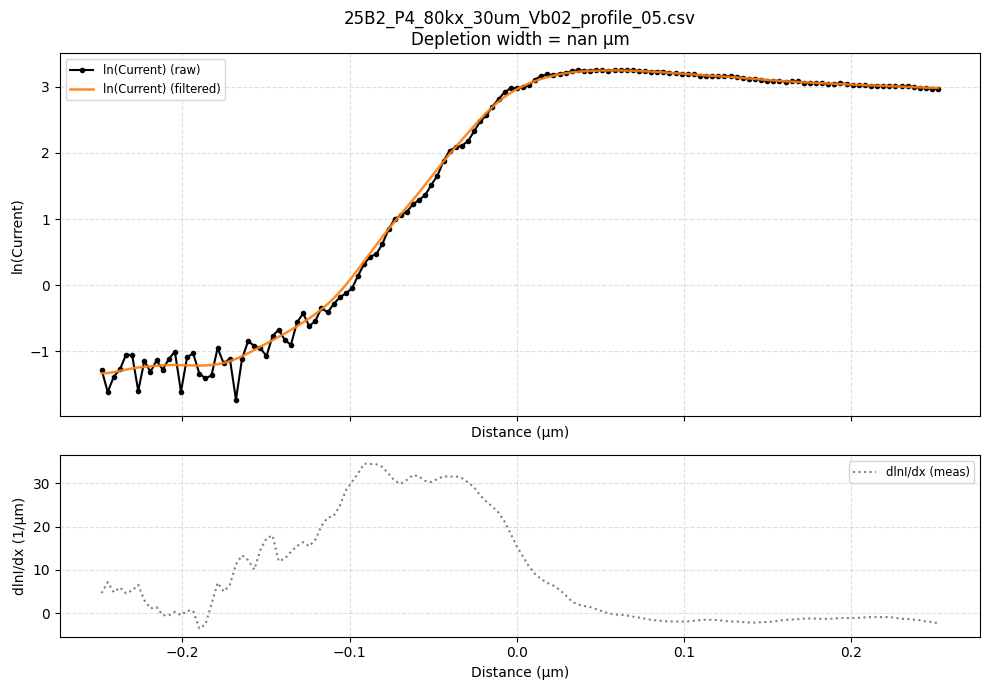

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


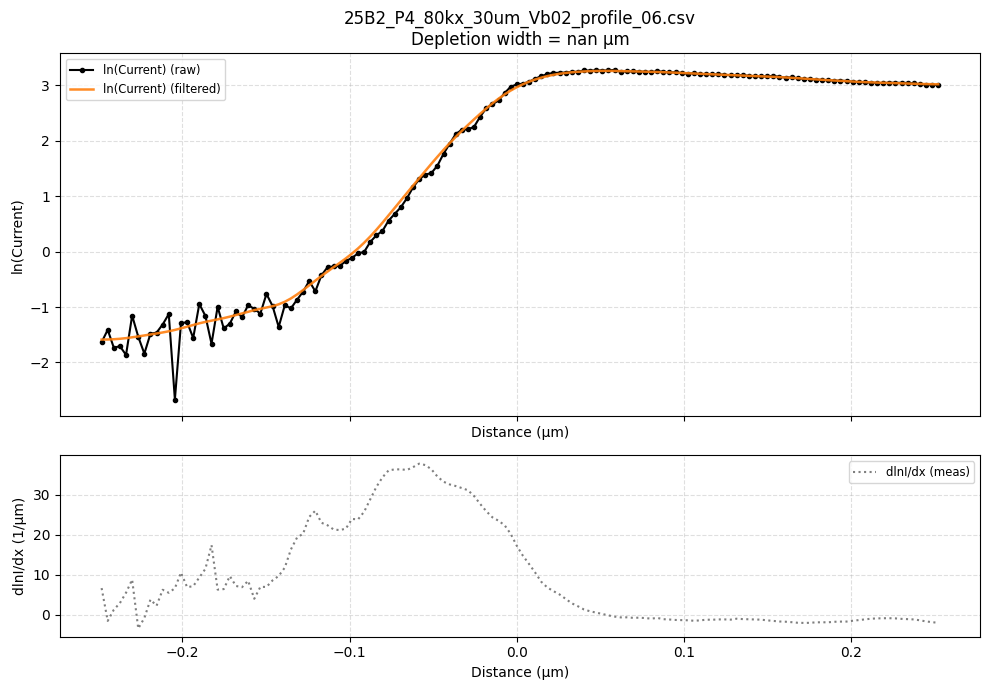

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


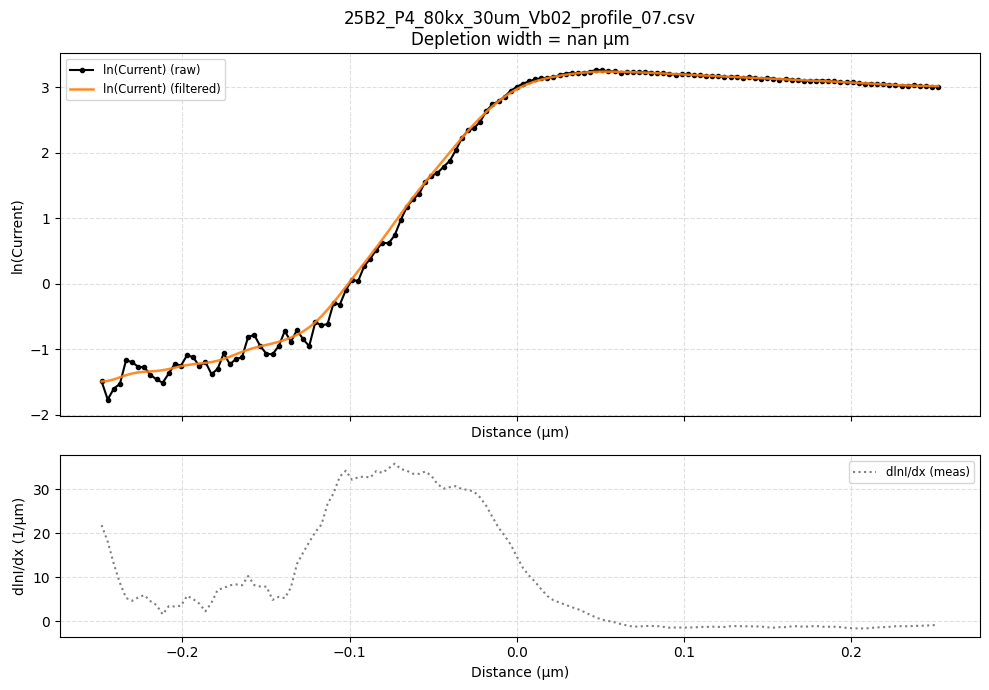

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


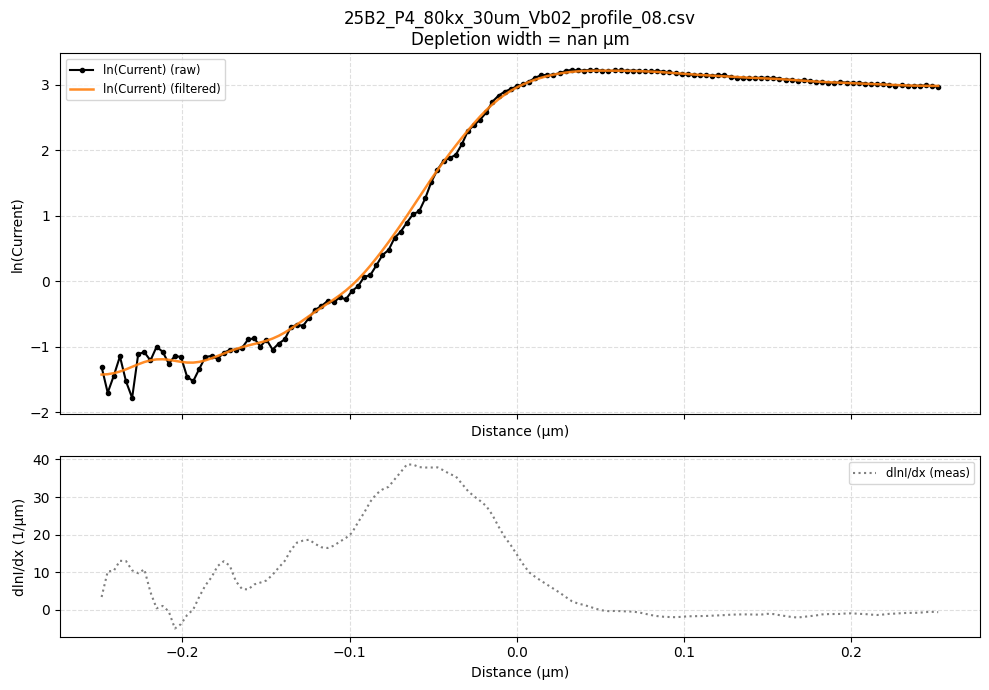

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


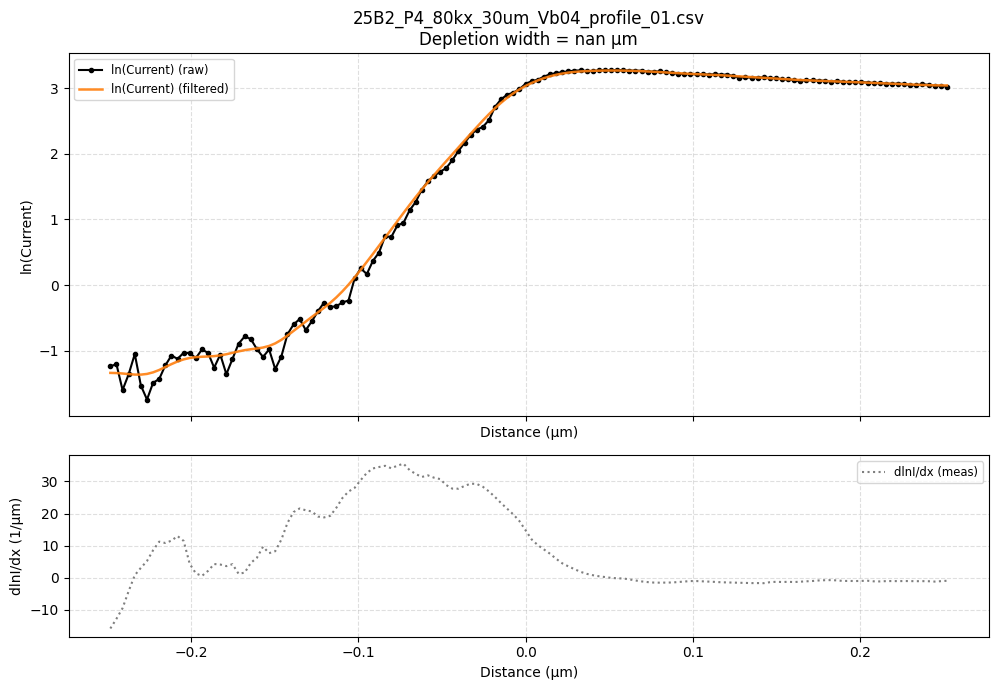

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


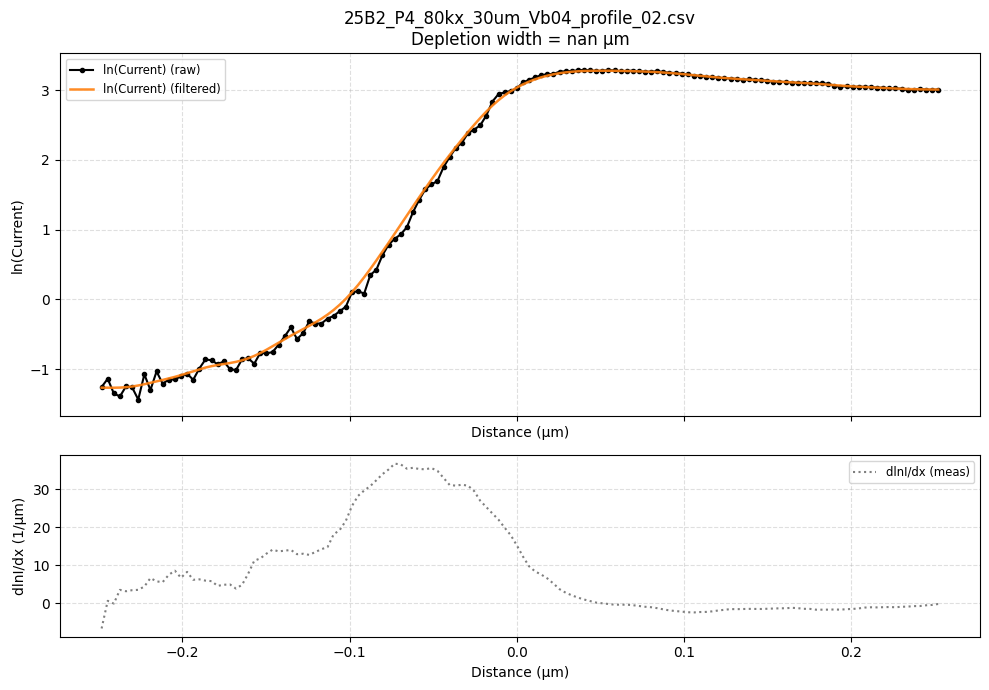

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


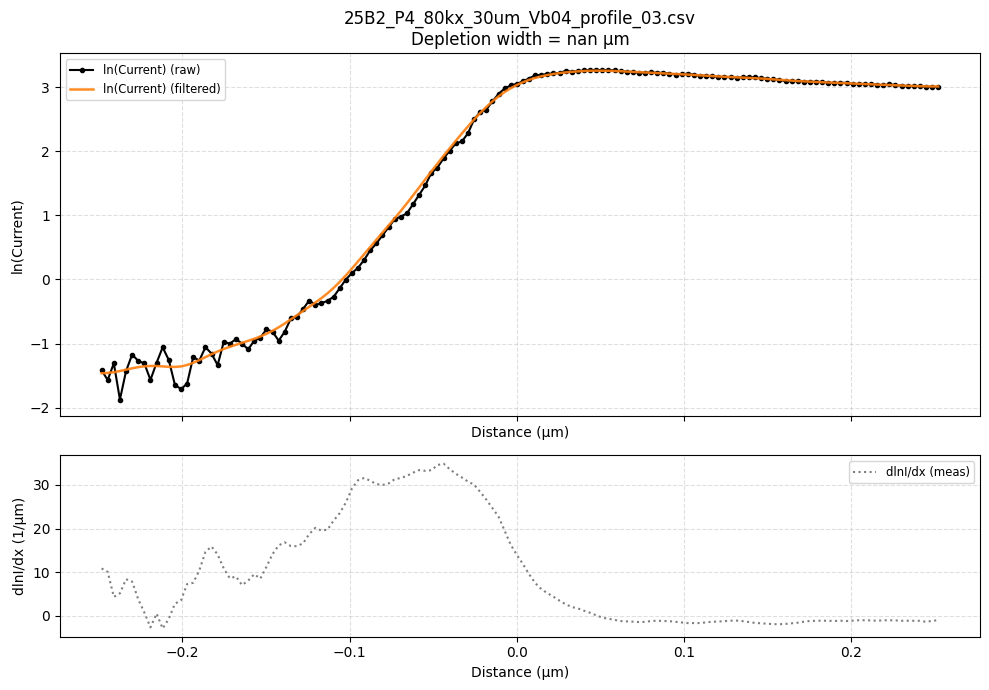

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


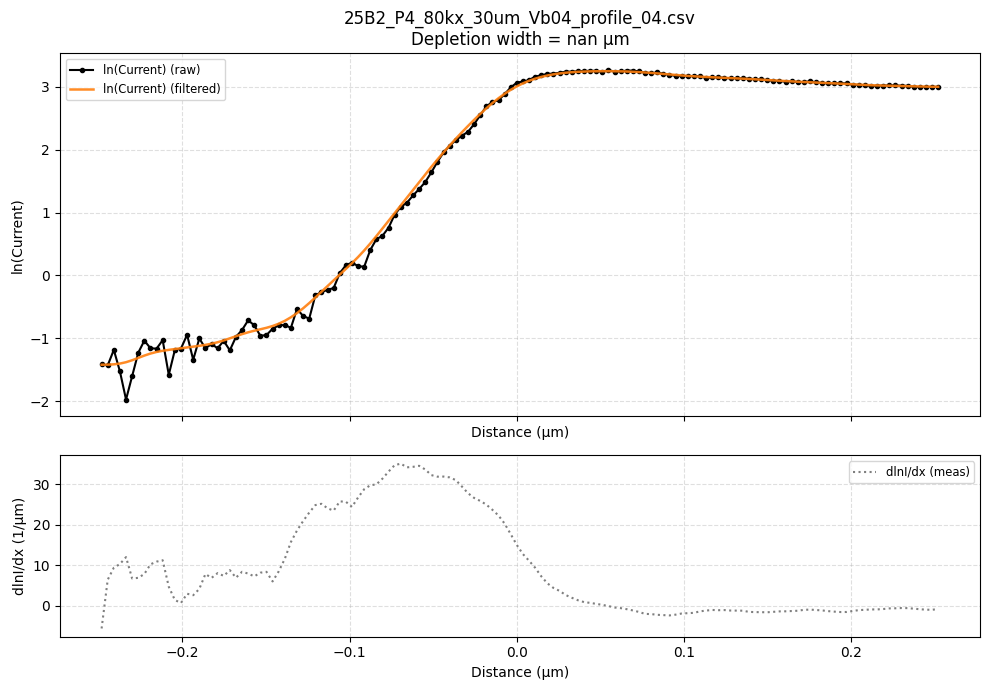

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


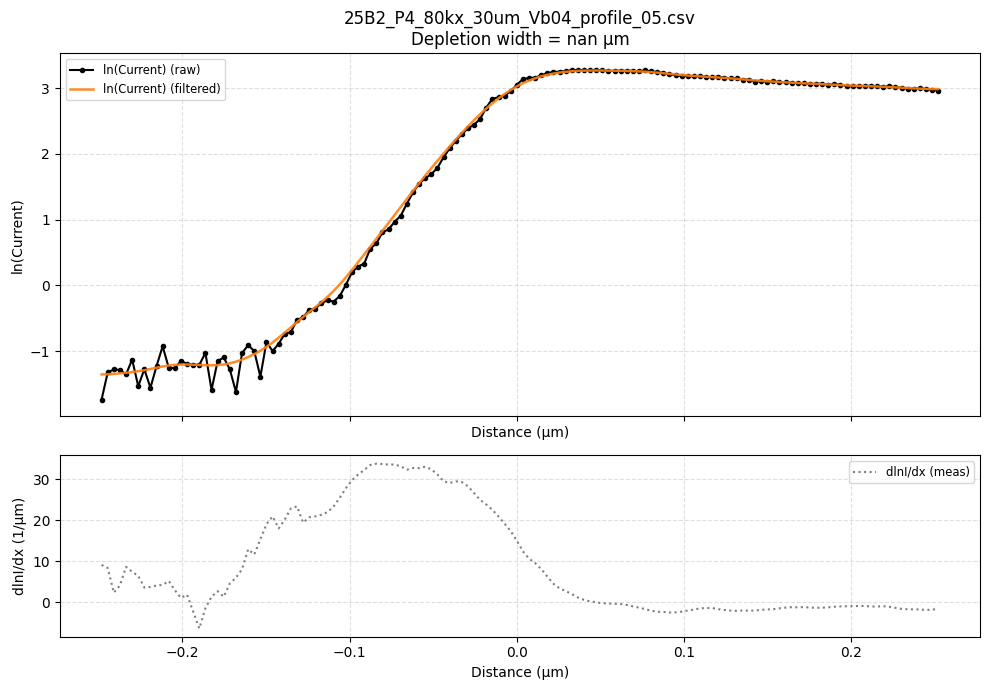

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


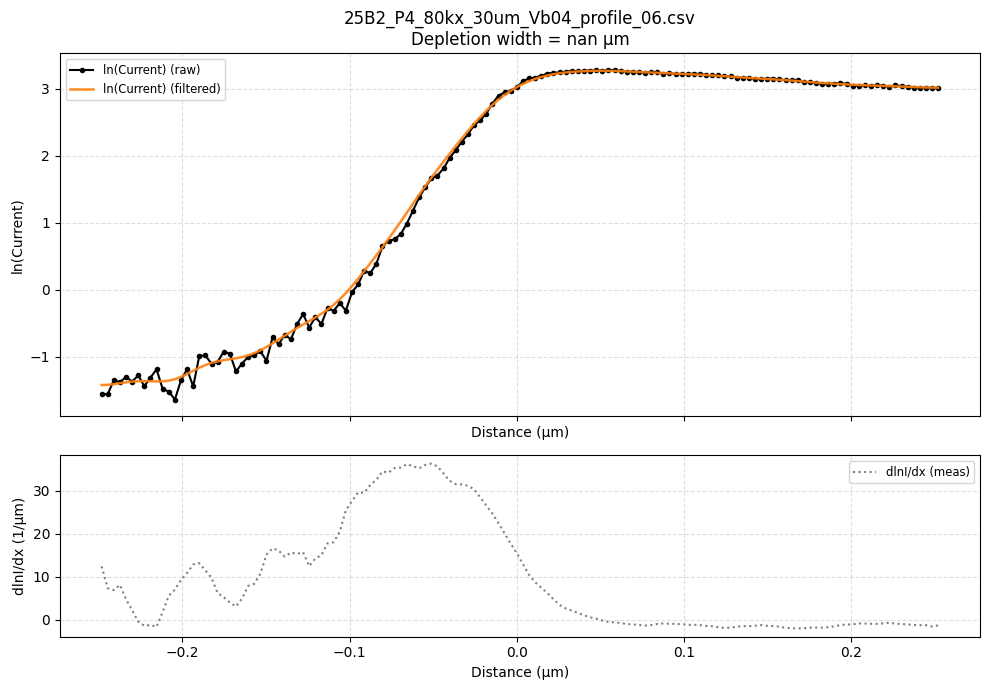

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


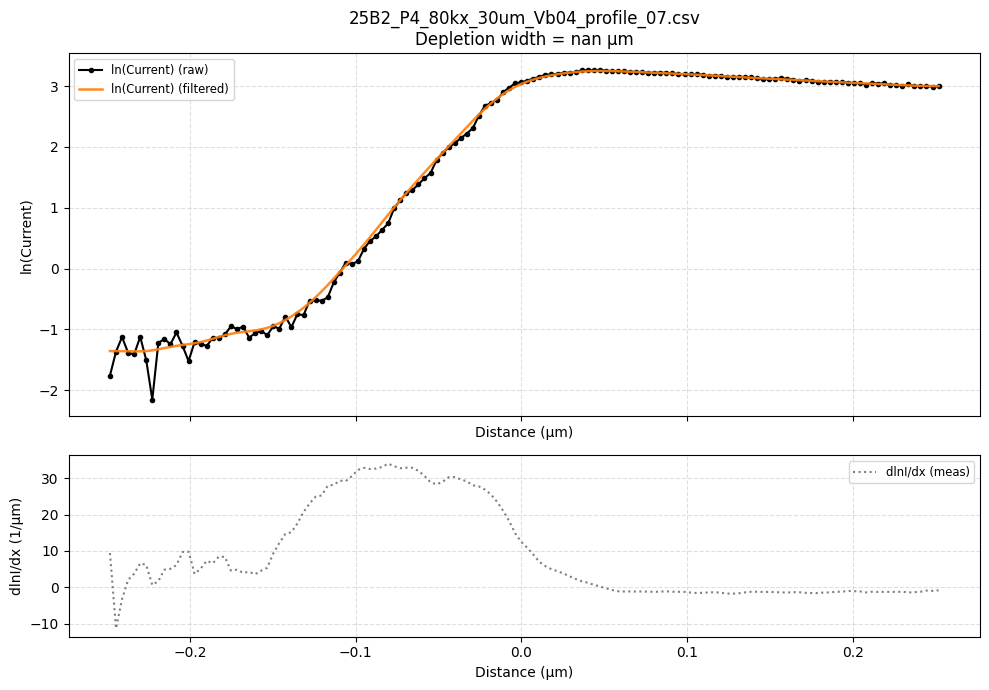

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


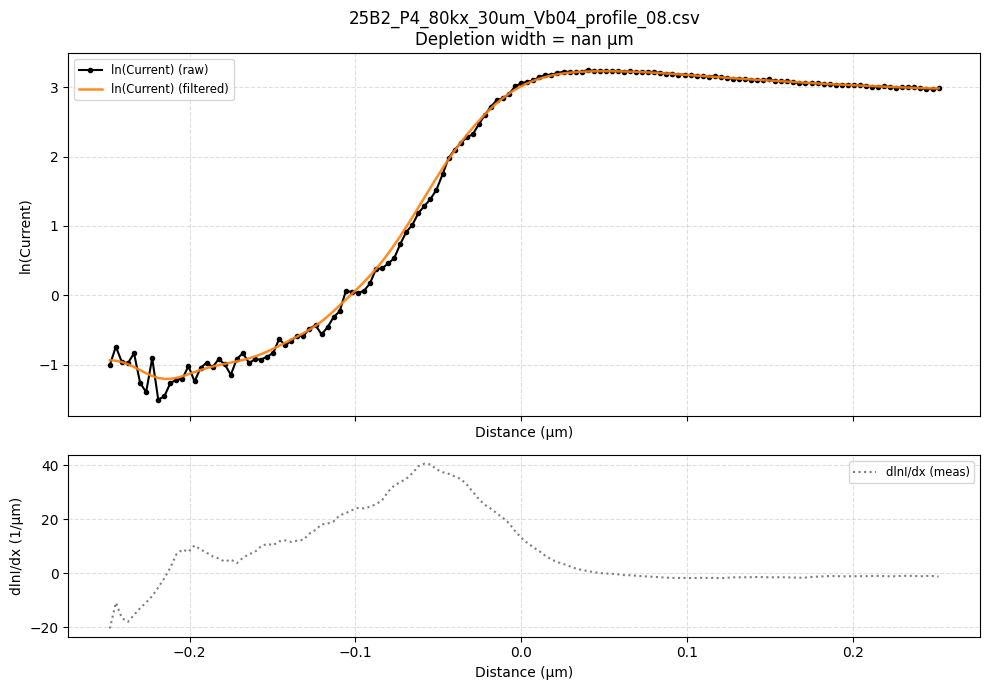

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


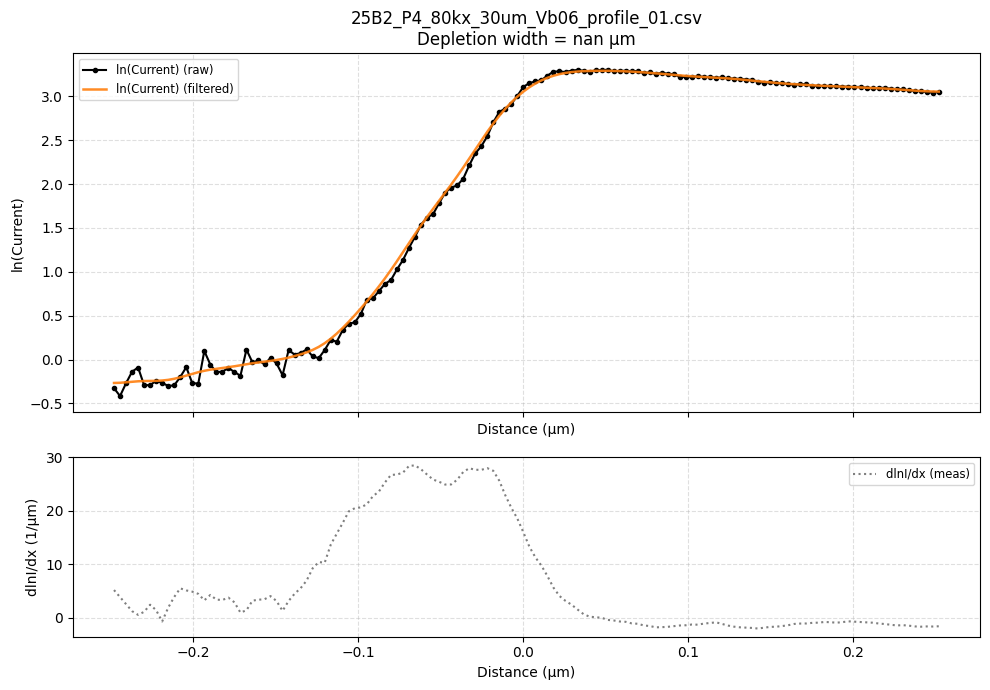

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


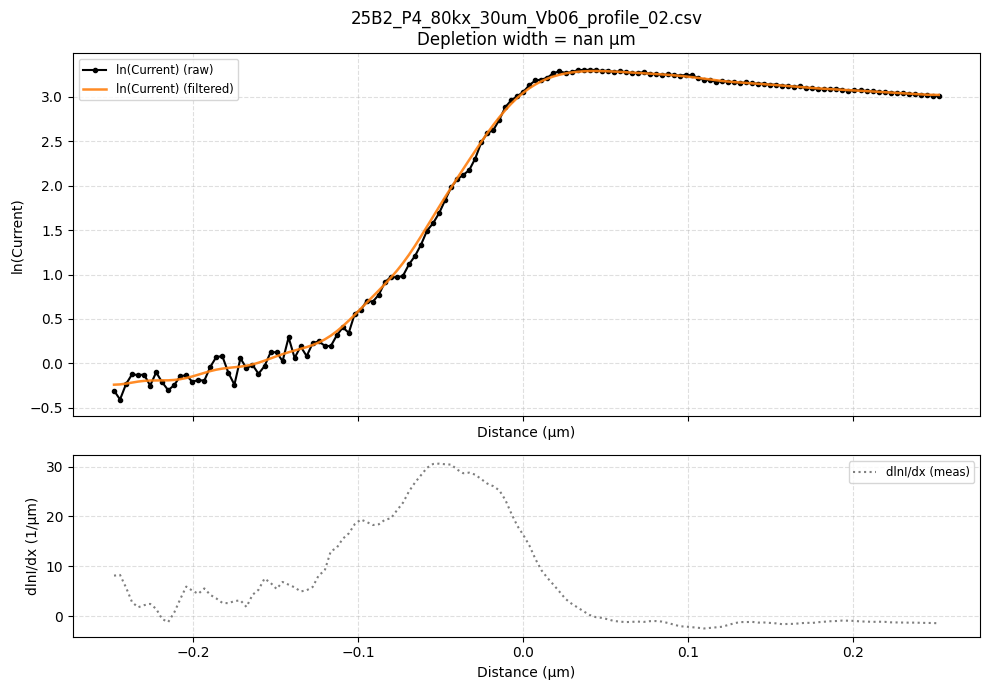

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


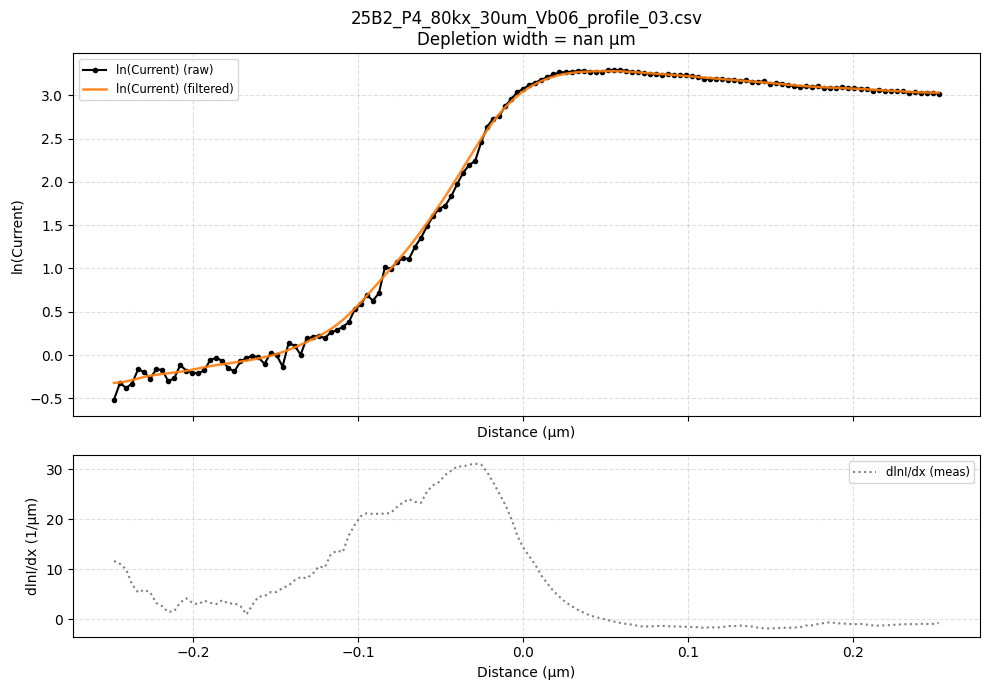

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


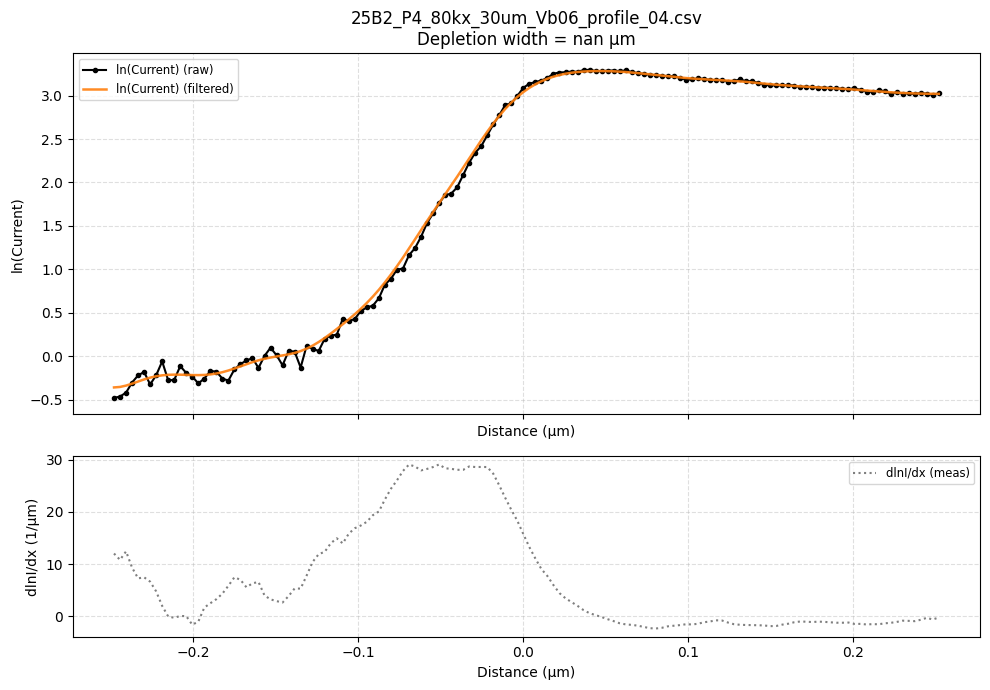

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


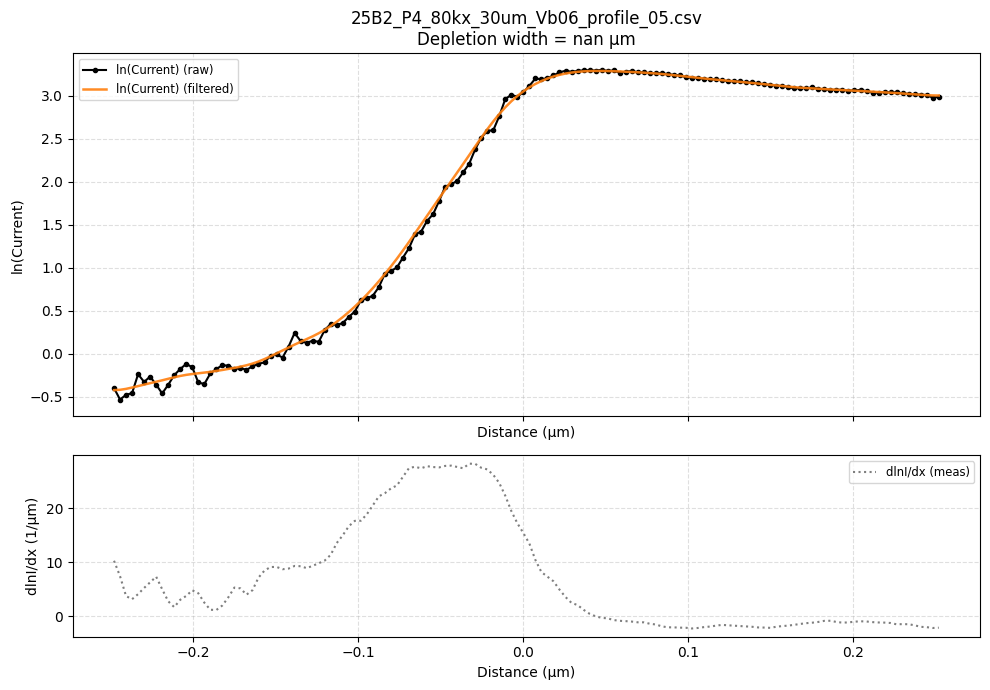

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


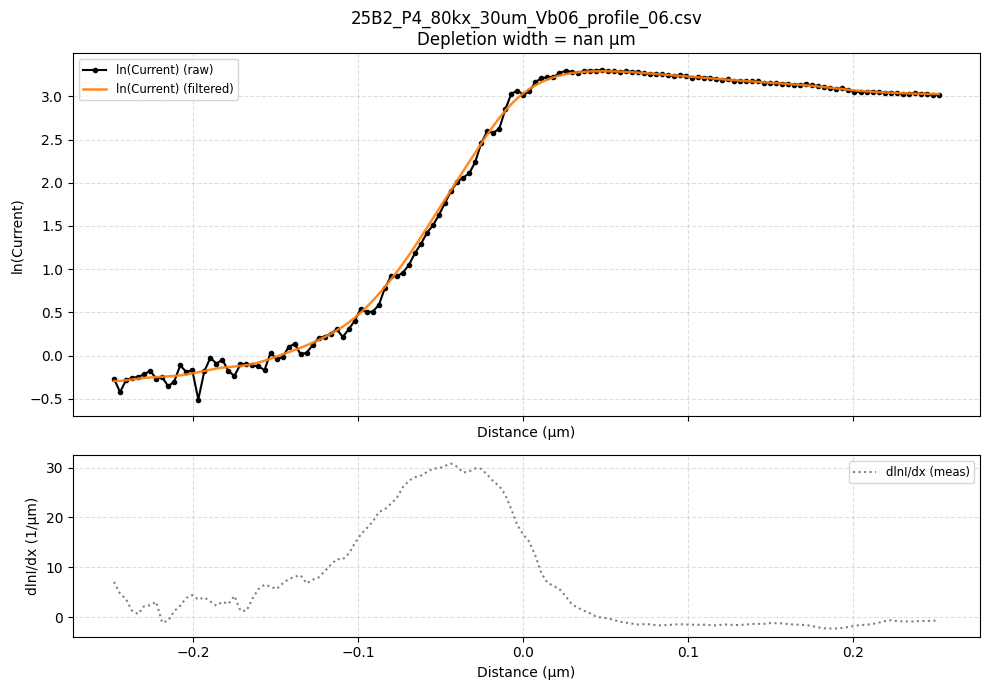

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


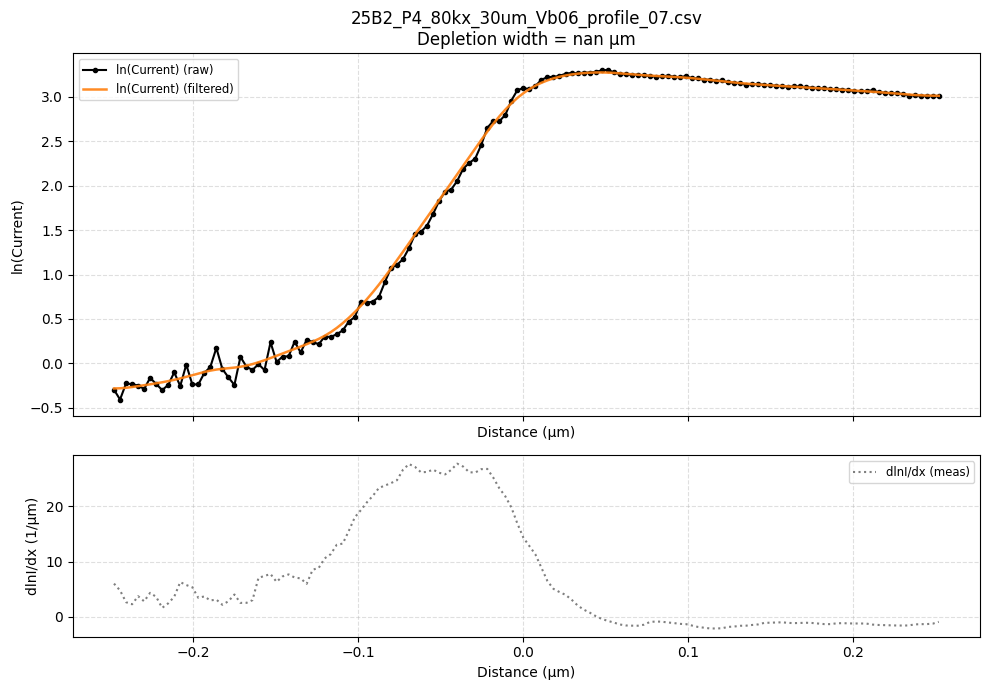

C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: divide by zero encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)
C:\Users\biselli\Desktop\Code\MasterThesis\EBIC_Analysis_Tool\code\DiffLenExt.py:987: RuntimeWarning: invalid value encountered in divide
  filter_mask = np.exp(-0.5 * (freqs / sigma) ** 2)


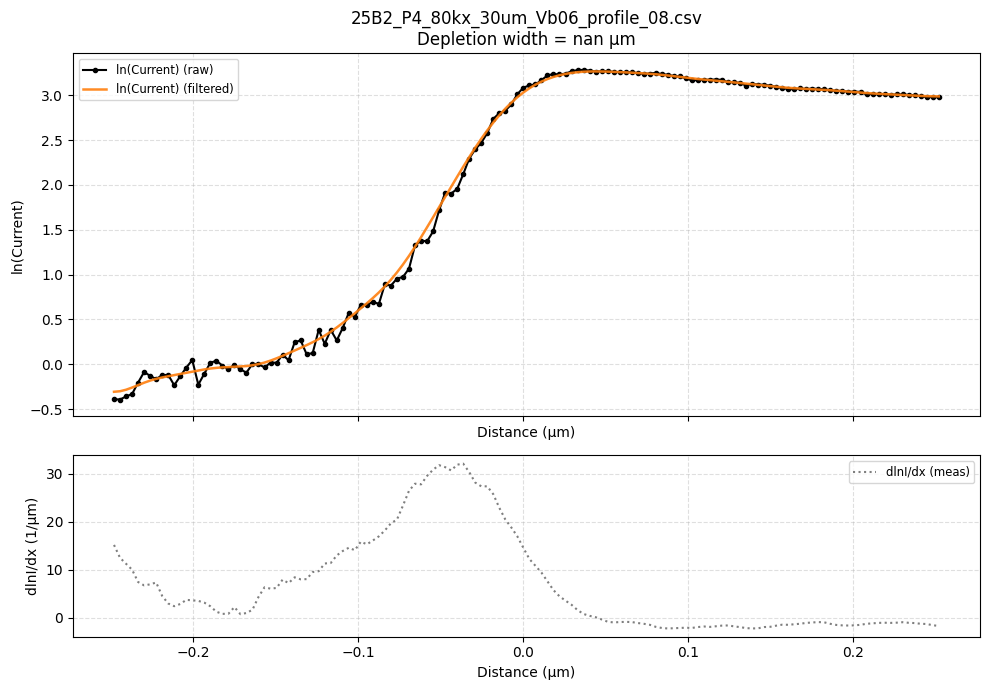


Completed processing 32 profiles


In [12]:
# ============================================
# ADJUST PARAMETERS HERE
# ============================================

params = {
    'use_plateau_detection': True,   # Use derivative plateau method
    'use_shifting': True,             # Enable iterative expansion
    'gradient_window': 13,             # Window size for derivative
    'min_plateau_length': 5,          # Minimum plateau size
    'derivative_threshold': 0.05,     # Max relative variation in derivative
    'absolute_threshold': 0.1,       # Max absolute variation (1/µm)
    'max_expansion': 1000,            # Max pixels to expand beyond plateau
    'consecutive_drops': 10,           # Stop after N consecutive R² drops
    'junction_precision': False,       # Start from junction to detect linearity onset
    'use_filtered_data': True,           # Enable filtering
    'filter_cutoff': 0,           # Low-pass filter cutoff (0 = no filtering)
}

# Run fitting for all selected profiles
extractors = fit_and_plot_profiles(csv_files, params)

print(f"\n{'='*60}")
print(f"Completed processing {len(extractors)} profiles")
print('='*60)


C:\Users\biselli\AppData\Local\Temp\ipykernel_21960\3680340411.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  b = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, showfliers=True)
C:\Users\biselli\AppData\Local\Temp\ipykernel_21960\3680340411.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  b = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, showfliers=True)
C:\Users\biselli\AppData\Local\Temp\ipykernel_21960\3680340411.py:152: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  b = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, showfliers=True)
C:\Users\biselli\AppData\Local\Tem

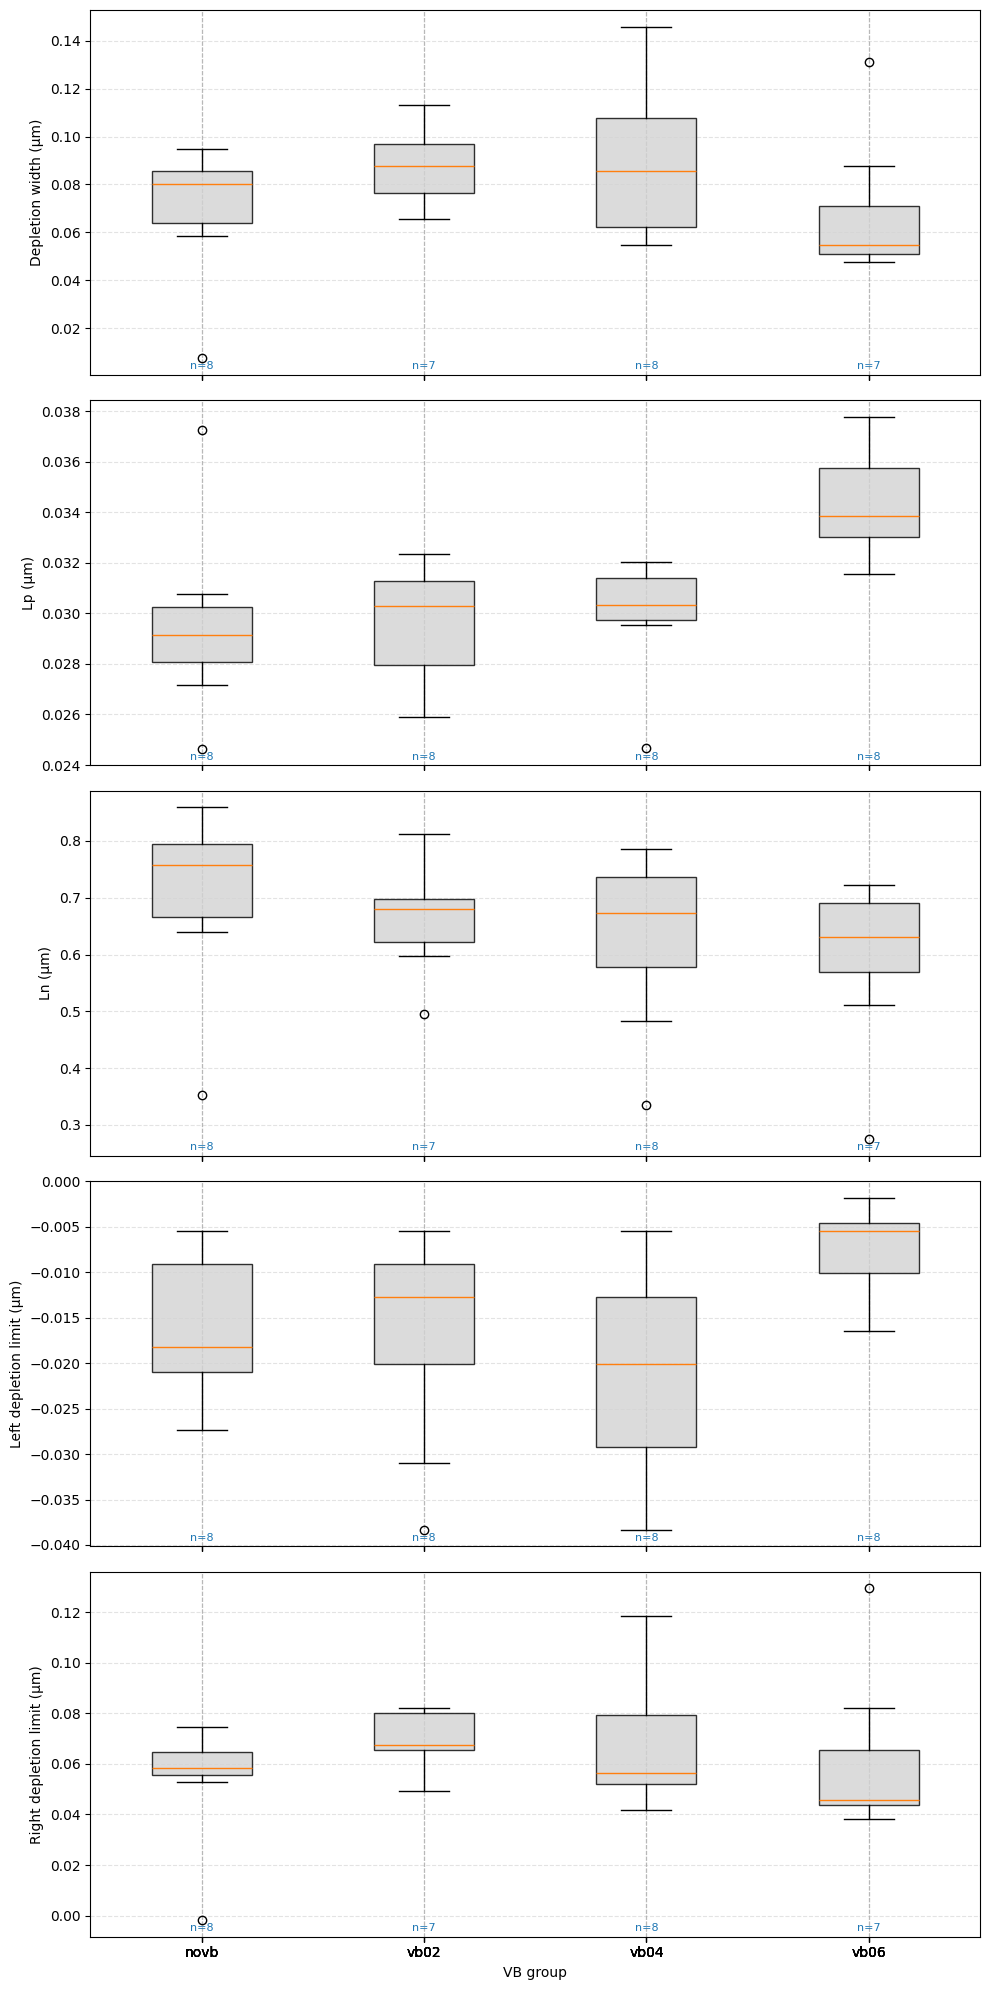

Per-VB medians and counts:
     depletion        inv_left inv_right left_start right_start
        median count    median    median     median      median
vb                                                             
novb  0.080292     8  0.029140  0.757088  -0.018248    0.058394
vb02  0.087591     7  0.030300  0.680633  -0.012774    0.067518
vb04  0.085766     8  0.030343  0.672905  -0.020073    0.056569
vb06  0.054745     7  0.033838  0.630581  -0.005474    0.045620


C:\Users\biselli\AppData\Local\Temp\ipykernel_21960\3680340411.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = results_df.groupby('vb').agg({


In [8]:
import re
import numpy as np

# Collect per-profile metrics from existing extractor objects and plot boxplots

def _extract_vb_from_name(name):
    # return standardized vb label (e.g. 'vb06' or 'novb')
    if name is None:
        return 'unknown'
    n = name.lower()
    m = re.search(r'novb', n)
    if m:
        return 'novb'
    m = re.search(r'vb0?\d+', n)
    if m:
        return m.group(0)
    # fallback: look for numeric vb like '02' or explicit tokens
    m = re.search(r'\b0?\d\b', n)
    return m.group(0) if m else 'unknown'

def collect_results_from_extractors(extractors):
    rows = []
    for ext in extractors:
        # ext.results may contain multiple profile results
        res_list = getattr(ext, 'results', []) or []
        profiles = getattr(ext, 'profiles', []) or []
        for res in res_list:
            try:
                # profile index may be stored in result
                profile_idx = int(res.get('Profile', 1)) - 1
            except Exception:
                profile_idx = 0
            src = None
            if 0 <= profile_idx < len(profiles):
                src = profiles[profile_idx].get('source_name') or profiles[profile_idx].get('source')
            # try alternate keys
            if src is None:
                src = res.get('source_name') or res.get('source') or getattr(ext, 'source_name', None)
            vb = _extract_vb_from_name(str(src))
            depletion = None
            left_slope = None
            right_slope = None
            left_start = None
            right_start = None
            try:
                depletion = res.get('depletion', {}).get('depletion_width', None)
                left = res.get('depletion', {}).get('best_left_fit') or {}
                right = res.get('depletion', {}).get('best_right_fit') or {}
                left_slope = left.get('slope', None)
                right_slope = right.get('slope', None)
                left_start = res.get('depletion', {}).get('left_start', None)
                right_start = res.get('depletion', {}).get('right_start', None)
            except Exception:
                pass
            # normalize slopes and reciprocals
            inv_left = None
            inv_right = None
            try:
                if left_slope is not None and left_slope != 0:
                    inv_left = 1.0 / abs(left_slope)
                if right_slope is not None and right_slope != 0:
                    inv_right = 1.0 / abs(right_slope)
            except Exception:
                inv_left = inv_right = None
            rows.append({
                'vb': vb,
                'source': str(src),
                'depletion': depletion,
                'left_slope': left_slope,
                'right_slope': right_slope,
                'inv_left': inv_left,
                'inv_right': inv_right,
                'left_start': left_start,
                'right_start': right_start
            })
    return pd.DataFrame(rows)

# Try to build per-profile DataFrame from extractors (preferred)
results_df = None
if 'extractors' in globals() and extractors:
    results_df = collect_results_from_extractors(extractors)

# Fallback: try to build from `summary` if no detailed results available
if (results_df is None) or results_df.empty:
    if 'summary' in globals() and isinstance(summary, pd.DataFrame):
        # Use per-vb aggregated medians as single entries (best-effort fallback)
        rows = []
        for vb_key in summary.index:
            row = summary.loc[vb_key].to_dict()
            # attempt to compute reciprocals from left_median/right_median
            left_s = row.get('left_median', np.nan)
            right_s = row.get('right_median', np.nan)
            inv_left = 1.0 / abs(left_s) if pd.notnull(left_s) and left_s != 0 else np.nan
            inv_right = 1.0 / abs(right_s) if pd.notnull(right_s) and right_s != 0 else np.nan
            rows.append({
                'vb': str(vb_key),
                'source': np.nan,
                'depletion': row.get('depletion_median', np.nan),
                'left_slope': left_s,
                'right_slope': right_s,
                'inv_left': inv_left,
                'inv_right': inv_right,
                'left_start': row.get('left_x0_median', np.nan),
                'right_start': row.get('right_x0_median', np.nan)
            })
        results_df = pd.DataFrame(rows)
    else:
        raise RuntimeError("No per-profile extractor results found and no 'summary' fallback available.")

# Clean and prepare for plotting
# Ensure vb is categorical with desired order if available
if 'vb_order' in globals() and isinstance(vb_order, (list, tuple)):
    unique_vbs = [v for v in vb_order if v in results_df['vb'].values]
else:
    unique_vbs = sorted(results_df['vb'].dropna().unique())

results_df = results_df.dropna(subset=['vb']).copy()
results_df['vb'] = pd.Categorical(results_df['vb'], categories=unique_vbs, ordered=True)

# Replace infinities and extremely large values with NaN for plotting
for col in ['inv_left', 'inv_right', 'depletion', 'left_start', 'right_start']:
    if col in results_df.columns:
        results_df[col] = pd.to_numeric(results_df[col], errors='coerce')
        results_df.loc[np.isinf(results_df[col]), col] = np.nan

# Prepare plot layout
metrics = [
    ('depletion', 'Depletion width (µm)'),
    ('inv_left', 'Lp (µm)'),
    ('inv_right', 'Ln (µm)'),
    ('left_start', 'Left depletion limit (µm)'),
    ('right_start', 'Right depletion limit (µm)')
]

# Filter only metrics that exist in results_df
metrics = [m for m in metrics if m[0] in results_df.columns]

n_plots = len(metrics)
fig, axes = plt.subplots(n_plots, 1, figsize=(10, 4 * n_plots), sharex=True)
if n_plots == 1:
    axes = [axes]

for ax, (col, ylabel) in zip(axes, metrics):
    # Prepare data in order
    data_to_plot = []
    labels = []
    for vb in unique_vbs:
        subset = results_df[results_df['vb'] == vb][col].dropna()
        data_to_plot.append(subset.values if subset.size > 0 else np.array([]))
        labels.append(vb)
    # Create boxplot; allow empty groups
    b = ax.boxplot(data_to_plot, labels=labels, patch_artist=True, showfliers=True)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.35, linestyle='--')
    # Improve coloring for visibility
    for patch in b['boxes']:
        patch.set(facecolor='lightgrey', alpha=0.8)
    # Annotate number of samples per vb
    for i, arr in enumerate(data_to_plot, start=1):
        ax.text(i, ax.get_ylim()[0] + 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                f"n={len(arr)}", ha='center', va='bottom', fontsize=8, color='tab:blue')

axes[-1].set_xlabel('VB group')
plt.tight_layout()
plt.show()

# Show short summary table (median per vb) for quick reference
summary_table = results_df.groupby('vb').agg({
    'depletion': ['median', 'count'],
    'inv_left': 'median',
    'inv_right': 'median',
    'left_start': 'median',
    'right_start': 'median'
})
print("Per-VB medians and counts:")
print(summary_table)

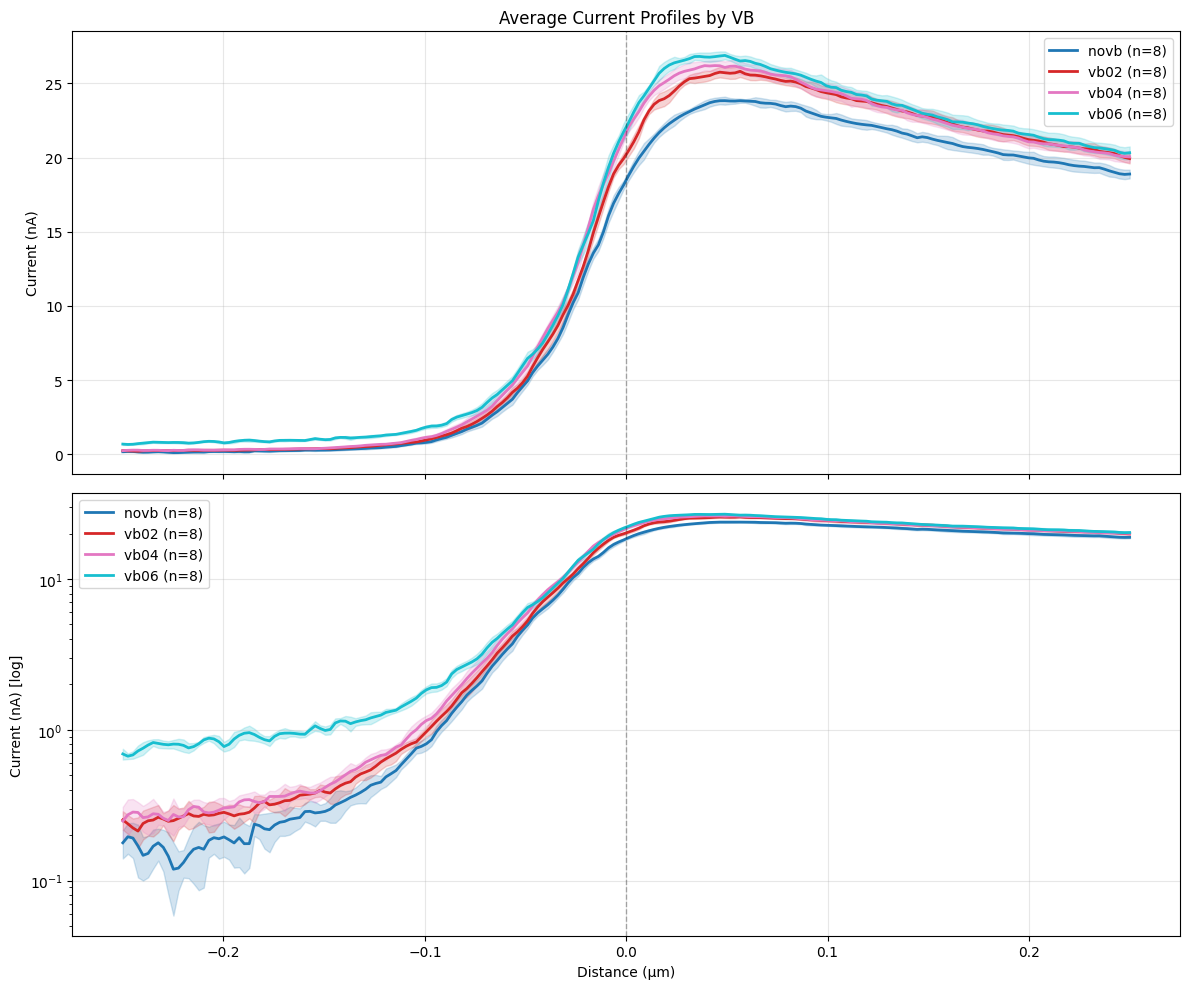


Average profile statistics:
novb: n=8, peak current=23.834 nA
vb02: n=8, peak current=25.811 nA
vb04: n=8, peak current=26.197 nA
vb06: n=8, peak current=26.881 nA


In [9]:
# Compute average current profile for each VB group

# Collect all profiles grouped by VB
vb_profiles = {}

for csv_file in csv_files:
    # Extract VB from filename
    vb = _extract_vb_from_name(csv_file.name)
    
    # Load profile data
    df_temp = pd.read_csv(csv_file)
    x = df_temp['distance_um'].values
    y = df_temp['current_nA'].values
    
    if vb not in vb_profiles:
        vb_profiles[vb] = {'x': [], 'y': []}
    
    vb_profiles[vb]['x'].append(x)
    vb_profiles[vb]['y'].append(y)

# Compute average for each VB (interpolate to common grid)
vb_averages = {}

for vb, data in vb_profiles.items():
    # Find common x range across all profiles
    x_min = max([x.min() for x in data['x']])
    x_max = min([x.max() for x in data['x']])
    
    # Create common grid
    x_common = np.linspace(x_min, x_max, 200)
    
    # Interpolate all profiles to common grid
    y_interpolated = []
    for x_orig, y_orig in zip(data['x'], data['y']):
        y_interp = np.interp(x_common, x_orig, y_orig)
        y_interpolated.append(y_interp)
    
    # Compute mean and std
    y_mean = np.mean(y_interpolated, axis=0)
    y_std = np.std(y_interpolated, axis=0)
    
    vb_averages[vb] = {
        'x': x_common,
        'y_mean': y_mean,
        'y_std': y_std,
        'n': len(data['x'])
    }

# Plot average profiles
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_vbs)))

for vb, color in zip(unique_vbs, colors):
    if vb in vb_averages:
        avg = vb_averages[vb]
        
        # Linear scale
        ax1.plot(avg['x'], avg['y_mean'], '-', color=color, linewidth=2, 
                label=f"{vb} (n={avg['n']})")
        ax1.fill_between(avg['x'], 
                        avg['y_mean'] - avg['y_std'], 
                        avg['y_mean'] + avg['y_std'],
                        color=color, alpha=0.2)
        
        # Log scale
        y_safe = np.maximum(avg['y_mean'], 1e-12)
        y_upper = np.maximum(avg['y_mean'] + avg['y_std'], 1e-12)
        y_lower = np.maximum(avg['y_mean'] - avg['y_std'], 1e-12)
        
        ax2.plot(avg['x'], y_safe, '-', color=color, linewidth=2,
                label=f"{vb} (n={avg['n']})")
        ax2.fill_between(avg['x'], y_lower, y_upper, color=color, alpha=0.2)

ax1.axvline(0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax1.set_ylabel('Current (nA)')
ax1.set_title('Average Current Profiles by VB')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.axvline(0, color='k', linestyle='--', alpha=0.3, linewidth=1)
ax2.set_xlabel('Distance (µm)')
ax2.set_ylabel('Current (nA) [log]')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAverage profile statistics:")
for vb in unique_vbs:
    if vb in vb_averages:
        avg = vb_averages[vb]
        print(f"{vb}: n={avg['n']}, peak current={avg['y_mean'].max():.3f} nA")

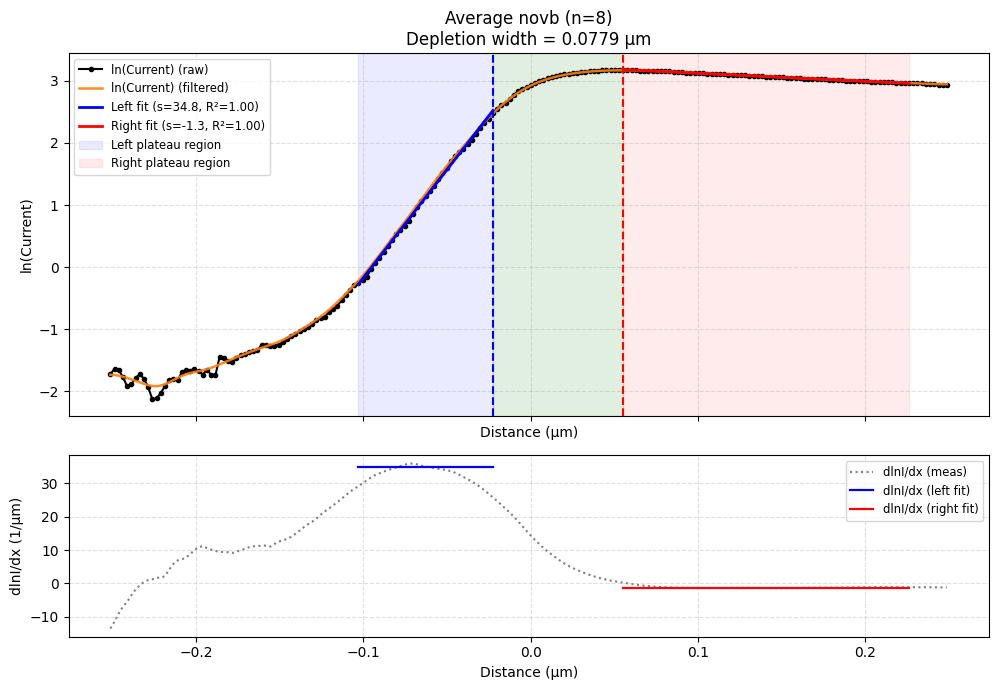

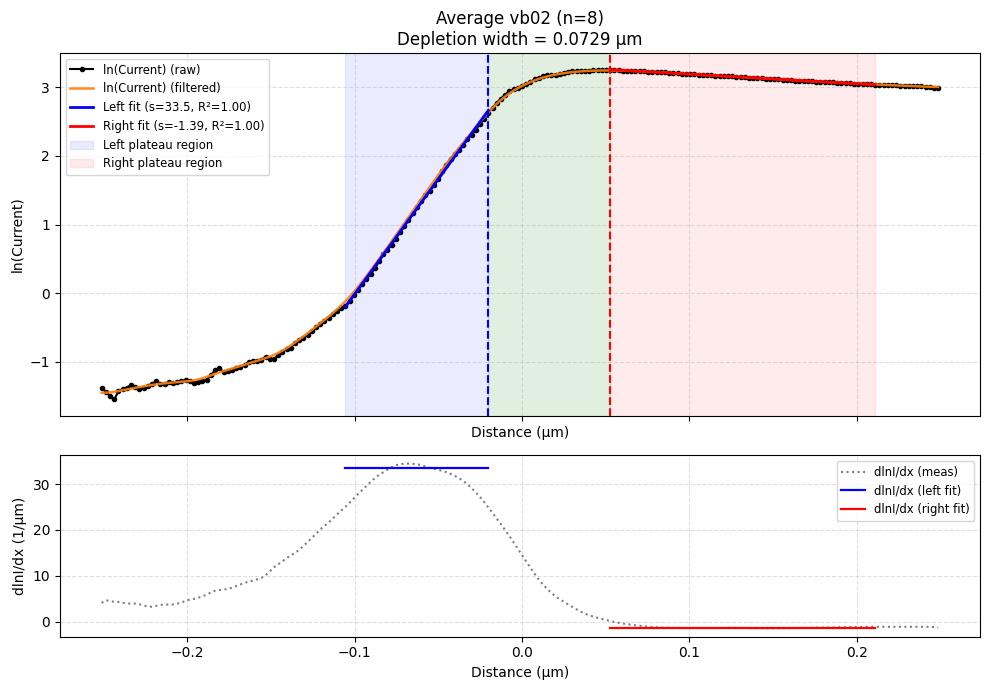

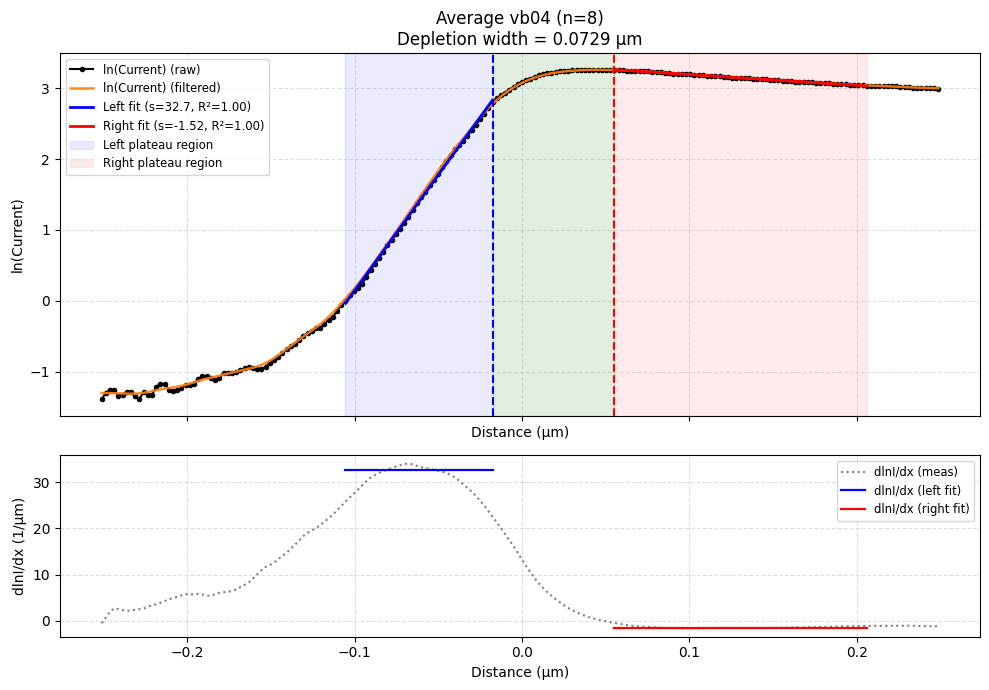

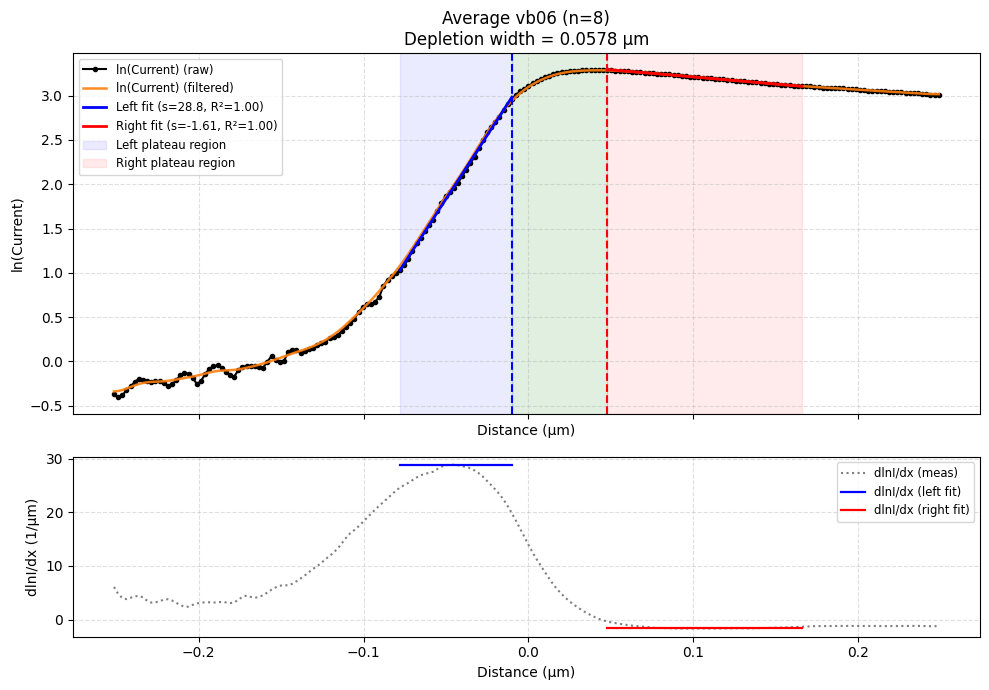


Completed fitting 4 average profiles

Average profile fitting results:
  VB  Depletion (µm)  Lp (µm)  Ln (µm)  Left slope  Right slope  n_profiles
novb        0.077889 0.028762 0.771923   34.767601    -1.295466           8
vb02        0.072864 0.029847 0.719414   33.504241    -1.390020           8
vb04        0.072864 0.030616 0.655995   32.662561    -1.524402           8
vb06        0.057789 0.034769 0.622988   28.761127    -1.605167           8


In [10]:
# Apply fitting to average profiles for each VB group

# Adjust parameters for average profiles (may need different settings)
avg_params = {
    'use_plateau_detection': True,
    'use_shifting': True,
    'gradient_window': 25,
    'min_plateau_length': 8,
    'derivative_threshold': 0.08,
    'absolute_threshold': 0.1,
    'max_expansion': 1000,
    'consecutive_drops': 20,
    'junction_precision': False
}

avg_extractors = []
pixel_size = 1e-6  # 1 µm

for vb in unique_vbs:
    if vb not in vb_averages:
        continue
    
    avg = vb_averages[vb]
    x_avg = avg['x']
    y_avg = avg['y_mean']
    
    # Find junction index (closest to x=0)
    junction_idx = int(np.argmin(np.abs(x_avg - 0.0)))
    
    # Create profile dict for average
    profile = {
        'id': 0,
        'dist_um': x_avg,
        'sem': np.zeros_like(x_avg),  # No SEM data for averaged profile
        'current': y_avg,
        'intersection_idx': junction_idx,
        'source_name': f'Average_{vb}_n{avg["n"]}'
    }
    
    # Initialize extractor and load profile
    extractor = DiffusionLengthExtractor(pixel_size, smoothing_sigma=1)
    extractor.load_profiles([profile])
    
    # Run fitting
    extractor.fit_all_profiles_linear(**avg_params)
    
    # Plot results
    plot_fitting_results(extractor, f'Average {vb} (n={avg["n"]})')
    
    avg_extractors.append({'vb': vb, 'extractor': extractor})

print(f"\n{'='*60}")
print(f"Completed fitting {len(avg_extractors)} average profiles")
print('='*60)

# Collect results from average profiles
avg_results = []
for item in avg_extractors:
    vb = item['vb']
    ext = item['extractor']
    
    if ext.results:
        res = ext.results[0]
        depletion = res.get('depletion', {})
        best_left = depletion.get('best_left_fit')
        best_right = depletion.get('best_right_fit')
        
        left_slope = best_left.get('slope') if best_left else None
        right_slope = best_right.get('slope') if best_right else None
        depl_width = depletion.get('depletion_width')
        
        inv_left = 1.0 / abs(left_slope) if left_slope and left_slope != 0 else None
        inv_right = 1.0 / abs(right_slope) if right_slope and right_slope != 0 else None
        
        avg_results.append({
            'VB': vb,
            'Depletion (µm)': depl_width,
            'Lp (µm)': inv_left,
            'Ln (µm)': inv_right,
            'Left slope': left_slope,
            'Right slope': right_slope,
            'n_profiles': vb_averages[vb]['n']
        })

# Display summary table
avg_summary = pd.DataFrame(avg_results)
print("\nAverage profile fitting results:")
print(avg_summary.to_string(index=False))

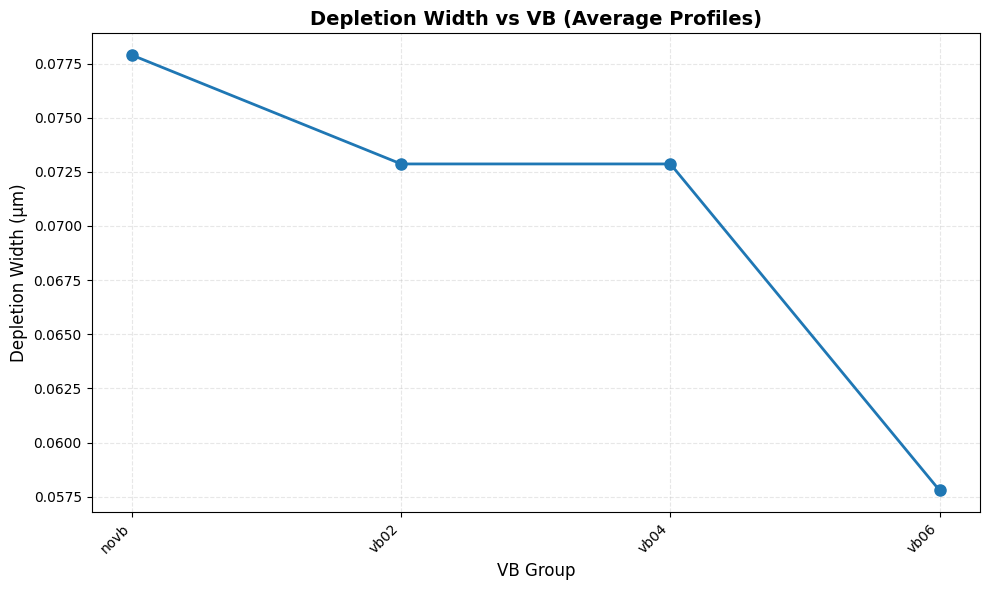


Depletion width vs VB:
novb: 0.078 µm
vb02: 0.073 µm
vb04: 0.073 µm
vb06: 0.058 µm


In [11]:
# Extract depletion width vs VB from average profile results
import matplotlib.pyplot as plt

# Prepare data for plotting
vb_labels = []
depletion_values = []

for vb in unique_vbs:
    if vb in vb_averages:
        # Find the corresponding result in avg_summary
        match = avg_summary[avg_summary['VB'] == vb]
        if not match.empty:
            depl = match.iloc[0]['Depletion (µm)']
            if pd.notnull(depl):
                vb_labels.append(vb)
                depletion_values.append(depl)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot as line with markers
ax.plot(vb_labels, depletion_values, 'o-', linewidth=2, markersize=8, color='tab:blue')

# Customize the plot
ax.set_xlabel('VB Group', fontsize=12)
ax.set_ylabel('Depletion Width (µm)', fontsize=12)
ax.set_title('Depletion Width vs VB (Average Profiles)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Also print the values
print("\nDepletion width vs VB:")
for vb, depl in zip(vb_labels, depletion_values):
    print(f"{vb}: {depl:.3f} µm")